In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D, Activation, MaxPooling1D, CuDNNLSTM
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [2]:
tf.__version__

'1.15.2'

In [3]:
 tf.test.is_gpu_available()

True

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
window_size = 6*60

In [364]:
train = pd.read_csv('train_timeframes3.csv')
test = pd.read_csv('test_timeframes3.csv')

In [365]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [366]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def normalize(data, window, step, ohlc_count=4):
    ohlc = data[step - window + 1:step + 1, :].copy()
    min_low = ohlc[:, :4].min()
    ohlc[:, :4] = ohlc[:, :4] - min_low

    max_high = ohlc[:, :4].max()
    ohlc[:, :4] = ohlc[:, :4] / max_high

    min_low = ohlc[:, 5:].min(axis=0)
    ohlc[:, 5:] = ohlc[:, 5:] - min_low

    max_high = ohlc[:, 5:].max(axis=0)
    ohlc[:, 5:] = ohlc[:, 5:] / max_high
    
    ohlc = np.nan_to_num(ohlc, copy=False, nan=0.0)
    return ohlc

In [407]:
values

['open_1min', 'high_1min', 'low_1min', 'close_1min', 'close_bid_1min']

In [367]:
frame = '_1min'
candlestick_c = ['open_1min', 'high_1min', 'low_1min', 'close_1min']
values = candlestick_c + [c for c in train.columns if c not in candlestick_c and frame in c]
ohlc = train[values].values

ohlc_test = test[values].values

In [368]:
margin_size = 50
time_limit = 30

In [369]:
%%time
inputs_train = []
for i in range(window_size-1, len(ohlc)):
    inputs_train.append(normalize(ohlc, window_size , i, ohlc_count=5))
inputs_train = np.array(inputs_train)

Wall time: 1min 30s


In [370]:
%%time
inputs_test = []
for i in range(window_size-1, len(test)):
    inputs_test.append(normalize(ohlc_test, window_size , i, ohlc_count=5))
inputs_test = np.array(inputs_test)

Wall time: 6.06 s


In [371]:
train = train.iloc[window_size-1:]
test = test.iloc[window_size-1:]

In [372]:
inputs_train = inputs_train[:-time_limit]
inputs_test = inputs_test[:-time_limit]

In [373]:
def meanm(y_true, y_pred):
    return tf.reduce_mean(y_pred)
def absmeanm(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_pred))
def minm(y_true, y_pred):
    return tf.reduce_min(y_pred)
def maxm(y_true, y_pred):
    return tf.reduce_max(y_pred)

In [374]:
def custom_loss_wrapper(margin_size):  
    def custom_loss(y_true, y_pred):        
        close1 = y_true[:,:1]
        close2 = y_true[:,1:2]
        diff = close2 - close1

        return tf.keras.losses.MSE(diff, y_pred[:,:1])
    return custom_loss

In [375]:
def get_return(data, t):
    preds = model.predict(data)
    diff = preds[:,:1] 
    r = 1.0
    invested = False
    i = 0
    while i < len(preds)-1:
        p = preds[i][0]
        if not invested and abs(p) > 2 * t['spread'].iloc[i]:
            invested = True
            buy_in = np.sign(p) * t['close_1min'].iloc[i]
        elif invested and np.sign(p) != np.sign(buy_in) and abs(p) > t['spread'].iloc[i]:
            invested = False
            r = r * (1 + margin_size * (t['close_1min'].iloc[i] - abs(buy_in) - np.sign(buy_in) * t['spread'].iloc[i])/buy_in)
        i += 1
    if invested:
        r = r * margin_size * (1 + (t['close_1min'].iloc[i] - abs(buy_in) - np.sign(buy_in) * t['spread'].iloc[i])/buy_in)
    return r

In [376]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        # Should be the label encoding of your classes
        pass
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
#             r_train = get_return(inputs_train, train.iloc[:-time_limit])
            r_test = get_return(inputs_test, test.iloc[:-time_limit])
            print()
#             print(f"Training Profits: {r_train} ---- Testing Profits: {r_test}")
            print(f"Testing Profits: {r_test}")
        

In [377]:
y_true = train['close_1min'].values[time_limit:] - train['close_1min'].values[:-time_limit]
y_true_test = test['close_1min'].values[time_limit:] - test['close_1min'].values[:-time_limit]

callback = MyCustomCallback()

In [405]:
inputs_train.mean()

0.6255361080820991

In [382]:
def get_model():
    model = models.Sequential()
    # model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
    model.add(CuDNNLSTM(32, kernel_regularizer='l2', input_shape=norm.shape))
    # model.add(LSTM(32, dropout=0.2))
    model.add(Dense(1, activation = "linear"))
    return model

model = get_model()

In [383]:
model = get_model()

In [384]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001, clipnorm=1),
#     loss=custom_loss_wrapper(margin_size),
    loss='MSE',
    metrics=[absmeanm, meanm, minm, maxm],
    run_eagerly=False
)

In [385]:
batch_size = 32
model.fit(
    inputs_train, y_true, 
    validation_data=(inputs_test, y_true_test),
    epochs=2000,
    verbose=1,
    callbacks=[callback],
    use_multiprocessing=False,
    workers=2,
    max_queue_size=2,
    batch_size=batch_size,
    shuffle=True,
#     initial_epoch=9,
)

Train on 939751 samples, validate on 71697 samples
Epoch 1/2000
939712/939751 [============================>.] - ETA: 0s - loss: 1.2079e-04 - absmeanm: 3.6873e-04 - meanm: 4.4176e-06 - minm: -1.0410e-04 - maxm: 1.1468e-04
Testing Profits: 1.0
939751/939751 [==============================] - 841s 895us/sample - loss: 1.2079e-04 - absmeanm: 3.6873e-04 - meanm: 4.3978e-06 - minm: -1.0411e-04 - maxm: 1.1466e-04 - val_loss: 6.6056e-07 - val_absmeanm: 1.5664e-04 - val_meanm: -1.5664e-04 - val_minm: -1.5970e-04 - val_maxm: -1.5352e-04
Epoch 2/2000
939751/939751 [==============================] - 818s 870us/sample - loss: 1.1818e-06 - absmeanm: 2.3754e-04 - meanm: 4.4986e-06 - minm: 3.2657e-06 - maxm: 5.7255e-06 - val_loss: 6.2741e-07 - val_absmeanm: 6.3957e-05 - val_meanm: -6.3957e-05 - val_minm: -6.3958e-05 - val_maxm: -6.3956e-05
Epoch 3/2000
939751/939751 [==============================] - 817s 869us/sample - loss: 1.1754e-06 - absmeanm: 2.3342e-04 - meanm: 4.4772e-06 - minm: 3.6027e-06 - 

939751/939751 [==============================] - 812s 864us/sample - loss: 1.1729e-06 - absmeanm: 2.3591e-04 - meanm: 4.4680e-06 - minm: 4.4298e-06 - maxm: 4.5065e-06 - val_loss: 8.1352e-07 - val_absmeanm: 4.4179e-04 - val_meanm: -4.4179e-04 - val_minm: -4.4179e-04 - val_maxm: -4.4179e-04
Epoch 25/2000
939751/939751 [==============================] - 812s 864us/sample - loss: 1.1740e-06 - absmeanm: 2.3648e-04 - meanm: 4.4869e-06 - minm: 4.4543e-06 - maxm: 4.5196e-06 - val_loss: 6.6957e-07 - val_absmeanm: 2.2532e-04 - val_meanm: -2.2532e-04 - val_minm: -2.2532e-04 - val_maxm: -2.2532e-04
Epoch 26/2000
939696/939751 [============================>.] - ETA: 0s - loss: 1.1714e-06 - absmeanm: 2.3327e-04 - meanm: 4.4953e-06 - minm: 4.4670e-06 - maxm: 4.5238e-06
Testing Profits: 1.0194598563968669
939751/939751 [==============================] - 827s 880us/sample - loss: 1.1714e-06 - absmeanm: 2.3327e-04 - meanm: 4.4763e-06 - minm: 4.4479e-06 - maxm: 4.5048e-06 - val_loss: 6.6219e-07 - val_abs

939751/939751 [==============================] - 820s 873us/sample - loss: 1.1759e-06 - absmeanm: 2.3910e-04 - meanm: 4.5020e-06 - minm: 4.4906e-06 - maxm: 4.5133e-06 - val_loss: 6.8038e-07 - val_absmeanm: 2.4620e-04 - val_meanm: -2.4620e-04 - val_minm: -2.4621e-04 - val_maxm: -2.4618e-04
Epoch 48/2000
939751/939751 [==============================] - 813s 865us/sample - loss: 1.1716e-06 - absmeanm: 2.3505e-04 - meanm: 4.4793e-06 - minm: 4.4710e-06 - maxm: 4.4876e-06 - val_loss: 6.3295e-07 - val_absmeanm: 8.7885e-05 - val_meanm: -8.7885e-05 - val_minm: -8.7886e-05 - val_maxm: -8.7885e-05
Epoch 49/2000
939751/939751 [==============================] - 812s 865us/sample - loss: 1.1749e-06 - absmeanm: 2.3796e-04 - meanm: 4.4719e-06 - minm: 4.4605e-06 - maxm: 4.4835e-06 - val_loss: 6.2498e-07 - val_absmeanm: 1.2766e-05 - val_meanm: -1.2766e-05 - val_minm: -1.2766e-05 - val_maxm: -1.2764e-05
Epoch 50/2000
939751/939751 [==============================] - 806s 857us/sample - loss: 1.1737e-06 - 

939744/939751 [============================>.] - ETA: 0s - loss: 1.1744e-06 - absmeanm: 2.3802e-04 - meanm: 4.4977e-06 - minm: 4.4936e-06 - maxm: 4.5019e-06
Testing Profits: 1.0194598563968669
939751/939751 [==============================] - 1017s 1ms/sample - loss: 1.1744e-06 - absmeanm: 2.3802e-04 - meanm: 4.4941e-06 - minm: 4.4899e-06 - maxm: 4.4982e-06 - val_loss: 6.8461e-07 - val_absmeanm: 2.5387e-04 - val_meanm: -2.5387e-04 - val_minm: -2.5387e-04 - val_maxm: -2.5387e-04
Epoch 72/2000
939751/939751 [==============================] - 928s 987us/sample - loss: 1.1746e-06 - absmeanm: 2.3755e-04 - meanm: 4.4581e-06 - minm: 4.4519e-06 - maxm: 4.4644e-06 - val_loss: 6.5951e-07 - val_absmeanm: 1.8144e-04 - val_meanm: 1.8144e-04 - val_minm: 1.8144e-04 - val_maxm: 1.8144e-04
Epoch 73/2000
939751/939751 [==============================] - 897s 954us/sample - loss: 1.1764e-06 - absmeanm: 2.4155e-04 - meanm: 4.5119e-06 - minm: 4.5075e-06 - maxm: 4.5162e-06 - val_loss: 6.3279e-07 - val_absmean

939751/939751 [==============================] - 931s 991us/sample - loss: 1.1738e-06 - absmeanm: 2.3499e-04 - meanm: 4.4778e-06 - minm: 4.4751e-06 - maxm: 4.4805e-06 - val_loss: 6.2926e-07 - val_absmeanm: 3.6980e-05 - val_meanm: -3.6980e-05 - val_minm: -3.6980e-05 - val_maxm: -3.6980e-05
Epoch 95/2000
939751/939751 [==============================] - 932s 992us/sample - loss: 1.1737e-06 - absmeanm: 2.3686e-04 - meanm: 4.4729e-06 - minm: 4.4702e-06 - maxm: 4.4755e-06 - val_loss: 6.2851e-07 - val_absmeanm: 2.7426e-05 - val_meanm: 2.7426e-05 - val_minm: 2.7425e-05 - val_maxm: 2.7426e-05
Epoch 96/2000
939744/939751 [============================>.] - ETA: 0s - loss: 1.1750e-06 - absmeanm: 2.3654e-04 - meanm: 4.4991e-06 - minm: 4.4950e-06 - maxm: 4.5032e-06 ETA: 0s - loss: 1.1749e-06 - absmeanm: 2.3653e-04 - meanm: 4.4708e-06 - minm: 4.4667e-06 - maxm: 4.4749e-
Testing Profits: 1.0
939751/939751 [==============================] - 1175s 1ms/sample - loss: 1.1750e-06 - absmeanm: 2.3654e-04 - m

939751/939751 [==============================] - 1138s 1ms/sample - loss: 1.1715e-06 - absmeanm: 2.3516e-04 - meanm: 4.4890e-06 - minm: 4.4868e-06 - maxm: 4.4910e-06 - val_loss: 7.2489e-07 - val_absmeanm: 3.1793e-04 - val_meanm: -3.1793e-04 - val_minm: -3.1793e-04 - val_maxm: -3.1793e-04
Epoch 118/2000
939751/939751 [==============================] - 1086s 1ms/sample - loss: 1.1728e-06 - absmeanm: 2.3444e-04 - meanm: 4.4718e-06 - minm: 4.4701e-06 - maxm: 4.4735e-06 - val_loss: 6.4384e-07 - val_absmeanm: 1.4382e-04 - val_meanm: -1.4382e-04 - val_minm: -1.4382e-04 - val_maxm: -1.4382e-04
Epoch 119/2000
939751/939751 [==============================] - 1105s 1ms/sample - loss: 1.1744e-06 - absmeanm: 2.3745e-04 - meanm: 4.4868e-06 - minm: 4.4846e-06 - maxm: 4.4889e-06 - val_loss: 7.2425e-07 - val_absmeanm: 3.1963e-04 - val_meanm: -3.1963e-04 - val_minm: -3.1963e-04 - val_maxm: -3.1963e-04
Epoch 120/2000
939751/939751 [==============================] - 1030s 1ms/sample - loss: 1.1731e-06 - a

KeyboardInterrupt: 

In [400]:
%%time
preds = model.predict(inputs_train)

Wall time: 4min 49s


In [386]:
%%time
preds_test = model.predict(inputs_test)

Wall time: 29.1 s


In [396]:
%%time
t = test.iloc[:-time_limit]
diff = preds_test[:,:1] 
r = 1.0
invested = False
i = 0
num_trades = 0
while i < len(preds_test)-1:
    p = preds_test[i][0]
    print(p)
    if not invested and abs(p) > t['spread'].iloc[i]:
        invested = True
        buy_in = np.sign(p) * t['close_1min'].iloc[i]
        num_trades += 1
    elif invested and np.sign(p) != np.sign(buy_in) and abs(p) > t['spread'].iloc[i]:
        invested = False
        r = r * (1 + margin_size*(t['close_1min'].iloc[i] - abs(buy_in) - np.sign(buy_in) * t['spread'].iloc[i])/buy_in)
    i += 1
if invested:
    r = r * (1 +  margin_size*(t['close_1min'].iloc[i] - abs(buy_in) - np.sign(buy_in) * t['spread'].iloc[i])/buy_in)

0.00020163339
0.00020163339
0.00020163336
0.00020163335
0.00020163335
0.00020163332
0.0002016333
0.00020163327
0.00020163326
0.00020163323
0.00020163323
0.00020163323
0.00020163326
0.00020163324
0.0002016332
0.00020163314
0.0002016331
0.00020163316
0.00020163311
0.00020163307
0.00020163307
0.00020163307
0.00020163304
0.00020163301
0.00020163301
0.00020163305
0.00020163303
0.00020163301
0.00020163308
0.00020163308
0.00020163305
0.0002016331
0.0002016331
0.00020163314
0.00020163314
0.00020163316
0.00020163321
0.00020163321
0.00020163321
0.00020163321
0.0002016332
0.0002016332
0.00020163327
0.00020163323
0.00020163326
0.00020163323
0.00020163326
0.00020163327
0.00020163327
0.0002016333
0.00020163329
0.00020163327
0.00020163324
0.00020163327
0.00020163324
0.0002016333
0.00020163336
0.00020163335
0.00020163337
0.0002016334
0.00020163339
0.00020163337
0.00020163337
0.00020163337
0.00020163342
0.00020163345
0.0002016334
0.00020163342
0.00020163346
0.00020163349
0.00020163345
0.00020163345
0.0

0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163316
0.00020163314
0.00020163316
0.00020163319
0.00020163319
0.00020163319
0.00020163317
0.00020163319
0.00020163317
0.00020163317
0.00020163316
0.00020163314
0.00020163314
0.00020163316
0.00020163316
0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163313
0.00020163313
0.00020163313
0.00020163313
0.00020163311
0.00020163311
0.0002016331
0.0002016331
0.0002016331
0.0002016331
0.00020163311
0.0002016331
0.0002016331
0.0002016331
0.00020163308
0.00020163313
0.00020163313
0.00020163314
0.00020163314
0.00020163314
0.00020163313
0.00020163313
0.00020163313
0.00020163313
0.00020163314
0.00020163313
0.00020163313
0.00020163313
0.00020163314
0.00020163317
0.00020163317
0.00020163316
0.00020163317
0.00020163316
0.00020163319
0.0002016332
0.0002016332
0.0002016332
0.0002016332
0.0002016332
0.00020163319
0.00020163319
0.00020163317
0.00020163316
0.00020163317
0.00020163316
0.00020163316
0.00

0.00020163288
0.00020163287
0.00020163287
0.00020163287
0.00020163287
0.00020163285
0.00020163285
0.00020163285
0.00020163285
0.00020163285
0.00020163285
0.00020163285
0.00020163285
0.00020163287
0.00020163287
0.00020163288
0.00020163288
0.00020163288
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.00020163291
0.00020163291
0.0002016329
0.00020163291
0.00020163291
0.00020163291
0.00020163292
0.00020163291
0.00020163291
0.00020163291
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.00020163291
0.00020163291
0.00020163291
0.0002016329
0.0002016329
0.00020163291
0.0002016329


0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163343
0.00020163343
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163342
0.00020163342
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.00020163343
0.00020163342
0.00020163342
0.00020163343
0.00020163343
0.00020163345
0.00020163345
0.00020163345
0.00020163345
0.00020163343
0.00020163342
0.0002016334
0.00020163342
0.0002016334
0.0002016334
0.0002016334
0.0002016334
0.0002016334
0.00020163343
0.00020163342
0.00020163343
0.00020163342
0.0002016334
0.0002016334
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0.00020163336
0.00020163336
0.00020163336
0.00020163337


0.00020163294
0.00020163294
0.00020163294
0.00020163294
0.00020163295
0.00020163295
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163298
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163295
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163297
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163295
0.00020163297
0.00020163297
0.00020163298
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163297
0.00020163298
0.00020163297
0.00020163297
0.00020163297
0.0002

0.0002016333
0.00020163326
0.00020163326
0.00020163327
0.00020163327
0.00020163324
0.00020163327
0.00020163326
0.00020163327
0.00020163329
0.00020163327
0.00020163327
0.00020163326
0.00020163329
0.00020163327
0.00020163332
0.00020163327
0.0002016333
0.00020163329
0.00020163329
0.00020163329
0.00020163332
0.00020163329
0.00020163333
0.00020163332
0.0002016333
0.00020163329
0.0002016333
0.00020163329
0.00020163327
0.00020163332
0.0002016333
0.00020163329
0.00020163329
0.00020163327
0.00020163326
0.00020163324
0.00020163321
0.00020163323
0.00020163321
0.00020163324
0.00020163324
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163324
0.00020163326
0.00020163327
0.00020163326
0.00020163323
0.00020163324
0.00020163324
0.00020163323
0.00020163327
0.00020163327
0.00020163326
0.00020163327
0.00020163326
0.00020163327
0.00020163326
0.00020163326
0.00020163326
0.00020163333
0.00020163335
0.00020163337
0.00020163337
0.00020163336
0.0002016334
0.0002016334
0.0002016334
0.00020163339


0.00020163327
0.00020163329
0.00020163327
0.00020163335
0.00020163333
0.00020163333
0.00020163333
0.00020163346
0.00020163343
0.0002016334
0.00020163337
0.00020163339
0.00020163342
0.00020163343
0.0002016334
0.00020163337
0.00020163337
0.00020163337
0.00020163335
0.00020163335
0.00020163333
0.00020163332
0.00020163332
0.00020163333
0.00020163333
0.00020163336
0.00020163336
0.00020163336
0.00020163333
0.00020163335
0.00020163333
0.00020163333
0.00020163332
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163332
0.00020163332
0.00020163333
0.00020163333
0.00020163332
0.00020163332
0.0002016333
0.0002016333
0.00020163329
0.00020163332
0.00020163332
0.00020163332
0.00020163332
0.00020163332
0.00020163332
0.00020163332
0.00020163333
0.00020163332
0.00020163332
0.00020163333
0.00020163332
0.0002016333
0.0002016333
0.00020163329
0.00020163329
0.00020163327
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.0002016332

0.0002016333
0.00020163327
0.00020163327
0.00020163327
0.0002016333
0.00020163327
0.00020163327
0.00020163326
0.00020163326
0.00020163333
0.00020163335
0.00020163335
0.0002016333
0.00020163326
0.00020163327
0.00020163324
0.00020163324
0.00020163327
0.00020163323
0.0002016332
0.00020163319
0.00020163316
0.00020163313
0.00020163316
0.00020163317
0.00020163316
0.00020163313
0.00020163316
0.00020163317
0.00020163316
0.00020163316
0.00020163317
0.0002016332
0.0002016332
0.00020163317
0.0002016332
0.00020163319
0.00020163317
0.00020163313
0.00020163313
0.00020163311
0.00020163311
0.00020163311
0.00020163314
0.00020163314
0.00020163313
0.00020163313
0.00020163311
0.0002016331
0.00020163308
0.0002016331
0.0002016331
0.00020163311
0.00020163316
0.00020163314
0.00020163319
0.00020163319
0.00020163317
0.00020163316
0.00020163314
0.00020163319
0.00020163319
0.0002016332
0.00020163319
0.00020163316
0.00020163314
0.00020163316
0.00020163314
0.00020163314
0.00020163313
0.00020163316
0.00020163317
0.0

0.00020163317
0.00020163316
0.00020163314
0.00020163313
0.00020163311
0.00020163311
0.00020163313
0.00020163313
0.00020163313
0.00020163311
0.0002016331
0.0002016331
0.0002016331
0.00020163308
0.0002016331
0.00020163308
0.00020163308
0.0002016331
0.00020163311
0.00020163313
0.00020163313
0.00020163314
0.00020163316
0.00020163316
0.00020163316
0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163313
0.00020163311
0.00020163313
0.0002016331
0.00020163307
0.00020163307
0.00020163305
0.00020163305
0.00020163305
0.00020163308
0.00020163307
0.00020163305
0.00020163314
0.00020163313
0.0002016331
0.00020163311
0.00020163308
0.0002016331
0.00020163308
0.00020163311
0.0002016331
0.0002016331
0.00020163305
0.00020163304
0.00020163305
0.00020163305
0.00020163307
0.00020163307
0.00020163308
0.0002016331
0.0002016331
0.00020163308
0.00020163311
0.00020163313
0.00020163313
0.00020163313
0.00020163314
0.00020163314
0.00020163316
0.00020163316
0.00020163317
0.00020163316
0.00020163316
0.00

0.00020163337
0.00020163336
0.00020163339
0.0002016334
0.00020163343
0.00020163345
0.0002016334
0.00020163342
0.0002016334
0.00020163337
0.00020163336
0.00020163333
0.00020163333
0.00020163332
0.00020163332
0.00020163333
0.00020163333
0.00020163335
0.00020163335
0.00020163336
0.00020163339
0.00020163336
0.00020163336
0.00020163342
0.00020163339
0.00020163337
0.00020163335
0.00020163336
0.00020163335
0.00020163337
0.00020163337
0.00020163336
0.00020163336
0.00020163336
0.00020163337
0.00020163336
0.00020163337
0.00020163335
0.00020163333
0.0002016333
0.0002016333
0.0002016333
0.0002016333
0.0002016333
0.00020163332
0.00020163333
0.0002016333
0.00020163333
0.00020163332
0.0002016333
0.00020163327
0.00020163329
0.00020163326
0.00020163326
0.00020163323
0.00020163324
0.00020163324
0.00020163324
0.00020163323
0.00020163321
0.00020163321
0.00020163323
0.00020163321
0.00020163321
0.0002016332
0.00020163321
0.0002016332
0.00020163323
0.00020163326
0.00020163324
0.00020163324
0.00020163324
0.00

0.00020163292
0.00020163291
0.0002016329
0.00020163288
0.0002016329
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.0002016329
0.00020163292
0.00020163291
0.0002016329
0.00020163288
0.0002016329
0.00020163288
0.00020163287
0.00020163287
0.00020163288
0.0002016329
0.00020163288
0.00020163291
0.0002016329
0.0002016329
0.0002016329
0.0002016329
0.00020163288
0.00020163291
0.0002016329
0.00020163288
0.0002016329
0.00020163288
0.00020163287
0.00020163287
0.00020163287
0.0002016329
0.00020163288
0.00020163288
0.00020163287
0.00020163288
0.00020163288
0.00020163287
0.0002016329
0.0002016329
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.00020163288
0.0002016329
0.0002016329
0.0002016329
0.00020163288
0.00020163287
0.00020163287
0.00020163285
0.0002016329
0.0002016329
0.00020163291
0.00020163291
0.0002016329
0.0002016329
0.00020163288
0.00020163288
0.0002016329
0

0.00020163321
0.0002016332
0.0002016332
0.00020163326
0.00020163327
0.00020163324
0.0002016332
0.00020163316
0.00020163313
0.00020163311
0.00020163311
0.0002016331
0.00020163308
0.00020163305
0.00020163307
0.00020163305
0.00020163303
0.00020163301
0.00020163301
0.00020163304
0.00020163304
0.00020163301
0.00020163298
0.00020163297
0.00020163297
0.00020163295
0.00020163297
0.00020163295
0.00020163294
0.000201633
0.00020163303
0.000201633
0.00020163304
0.00020163307
0.0002016331
0.00020163308
0.0002016331
0.00020163308
0.00020163305
0.00020163303
0.00020163304
0.00020163304
0.00020163303
0.00020163301
0.000201633
0.000201633
0.00020163303
0.00020163303
0.00020163308
0.00020163308
0.00020163308
0.00020163307
0.0002016331
0.00020163307
0.00020163303
0.00020163301
0.00020163304
0.00020163304
0.00020163303
0.00020163301
0.000201633
0.00020163301
0.00020163301
0.000201633
0.00020163297
0.00020163292
0.000201633
0.00020163295
0.00020163295
0.00020163294
0.00020163291
0.0002016329
0.0002016329
0

0.0002016334
0.00020163339
0.00020163339
0.00020163337
0.00020163337
0.00020163336
0.00020163336
0.00020163336
0.0002016334
0.00020163339
0.00020163337
0.00020163339
0.00020163337
0.0002016334
0.0002016334
0.0002016334
0.0002016334
0.00020163339
0.0002016334
0.00020163342
0.00020163343
0.00020163342
0.00020163342
0.0002016334
0.00020163342
0.00020163339
0.00020163339
0.00020163337
0.00020163336
0.00020163336
0.00020163335
0.00020163335
0.00020163336
0.00020163336
0.00020163335
0.00020163336
0.00020163337
0.00020163339
0.00020163337
0.00020163339
0.00020163336
0.00020163336
0.00020163336
0.00020163335
0.00020163336
0.00020163335
0.00020163336
0.00020163336
0.00020163336
0.00020163336
0.00020163337
0.00020163337
0.00020163337
0.00020163339
0.0002016334
0.00020163339
0.00020163339
0.00020163339
0.00020163339
0.00020163337
0.00020163339
0.00020163337
0.00020163336
0.00020163336
0.00020163336
0.00020163336
0.00020163336
0.00020163336
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0

0.00020163314
0.00020163317
0.00020163319
0.0002016332
0.00020163317
0.00020163319
0.00020163317
0.00020163316
0.00020163316
0.00020163316
0.00020163316
0.00020163316
0.00020163319
0.00020163319
0.00020163319
0.00020163317
0.00020163319
0.00020163321
0.00020163326
0.00020163327
0.00020163326
0.00020163324
0.00020163321
0.00020163323
0.00020163323
0.00020163324
0.00020163324
0.00020163324
0.00020163324
0.00020163323
0.00020163326
0.00020163324
0.00020163324
0.00020163323
0.00020163324
0.00020163323
0.00020163326
0.00020163326
0.00020163326
0.00020163335
0.00020163333
0.00020163332
0.00020163332
0.00020163332
0.0002016333
0.0002016333
0.00020163332
0.00020163329
0.00020163327
0.00020163324
0.00020163324
0.00020163326
0.0002016333
0.0002016333
0.00020163332
0.00020163332
0.00020163329
0.00020163327
0.00020163326
0.00020163327
0.00020163327
0.00020163329
0.0002016333
0.0002016333
0.00020163332
0.00020163335
0.00020163332
0.00020163332
0.0002016333
0.00020163335
0.00020163333
0.00020163339


0.00020163307
0.00020163307
0.00020163308
0.00020163308
0.00020163313
0.00020163313
0.00020163314
0.00020163314
0.00020163314
0.00020163316
0.00020163317
0.00020163319
0.00020163319
0.00020163319
0.0002016332
0.00020163319
0.00020163316
0.00020163317
0.0002016332
0.00020163323
0.00020163326
0.00020163324
0.00020163327
0.00020163323
0.00020163321
0.00020163321
0.0002016332
0.00020163323
0.00020163321
0.00020163319
0.00020163317
0.00020163323
0.00020163321
0.00020163321
0.00020163321
0.00020163323
0.00020163321
0.00020163324
0.00020163324
0.00020163323
0.00020163317
0.00020163313
0.0002016332
0.00020163317
0.00020163316
0.00020163314
0.00020163316
0.00020163314
0.00020163313
0.0002016331
0.00020163307
0.00020163308
0.00020163307
0.00020163308
0.00020163319
0.0002016332
0.00020163317
0.00020163314
0.00020163316
0.00020163317
0.00020163319
0.00020163316
0.00020163313
0.00020163311
0.0002016331
0.00020163308
0.00020163308
0.00020163307
0.00020163308
0.00020163307
0.0002016331
0.0002016331
0

0.00020163319
0.00020163316
0.00020163319
0.00020163317
0.00020163317
0.00020163316
0.00020163314
0.00020163313
0.00020163313
0.00020163314
0.00020163314
0.00020163314
0.00020163314
0.00020163313
0.00020163311
0.00020163308
0.00020163308
0.00020163305
0.00020163303
0.00020163303
0.00020163303
0.00020163301
0.00020163301
0.00020163304
0.00020163304
0.00020163303
0.00020163304
0.00020163303
0.00020163303
0.00020163301
0.00020163294
0.00020163295
0.00020163291
0.00020163291
0.00020163294
0.00020163292
0.00020163292
0.00020163292
0.00020163291
0.0002016329
0.00020163288
0.0002016329
0.0002016329
0.00020163295
0.00020163307
0.00020163304
0.00020163305
0.00020163308
0.00020163307
0.00020163305
0.00020163311
0.00020163307
0.00020163307
0.00020163304
0.00020163303
0.00020163303
0.00020163301
0.000201633
0.00020163297
0.00020163301
0.00020163297
0.00020163292
0.00020163292
0.00020163291
0.00020163291
0.00020163295
0.00020163294
0.00020163292
0.00020163292
0.00020163292
0.00020163294
0.000201632

0.0002016333
0.00020163329
0.00020163329
0.00020163327
0.00020163327
0.00020163327
0.0002016333
0.00020163329
0.00020163329
0.00020163327
0.00020163326
0.00020163326
0.00020163324
0.00020163326
0.00020163327
0.00020163327
0.00020163329
0.00020163329
0.0002016333
0.00020163332
0.0002016333
0.0002016333
0.0002016333
0.0002016333
0.00020163329
0.00020163326
0.00020163326
0.00020163326
0.00020163324
0.00020163324
0.00020163324
0.00020163323
0.00020163324
0.00020163326
0.00020163329
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163329
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.00020163329
0.00020163329
0.00020163327
0.00020163326
0.00020163327
0.00020163326
0.00020163326
0.00020163326
0.00020163326
0.00020163326
0.00020163326
0.00020163327
0.00020163327
0.00020163329
0.0002016333
0.0002016333
0.0002016333
0.00020163329
0.00020163329
0.00020163329
0.00020163327
0.00020163327
0.00020163327
0.00020163329
0.

0.00020163292
0.00020163292
0.00020163297
0.00020163298
0.000201633
0.000201633
0.00020163305
0.00020163305
0.00020163307
0.00020163307
0.00020163307
0.00020163308
0.0002016331
0.00020163316
0.00020163313
0.00020163317
0.0002016332
0.00020163321
0.00020163324
0.00020163324
0.00020163332
0.00020163333
0.00020163329
0.00020163329
0.00020163324
0.00020163324
0.00020163323
0.00020163323
0.00020163327
0.00020163326
0.00020163327
0.00020163327
0.0002016333
0.0002016333
0.00020163329
0.00020163327
0.00020163326
0.00020163327
0.00020163324
0.00020163323
0.00020163321
0.00020163326
0.00020163327
0.00020163327
0.00020163327
0.00020163327
0.0002016333
0.00020163329
0.00020163329
0.00020163329
0.00020163327
0.00020163332
0.00020163333
0.00020163333
0.00020163335
0.00020163336
0.00020163336
0.00020163335
0.00020163335
0.00020163333
0.00020163333
0.00020163333
0.00020163332
0.00020163332
0.00020163333
0.00020163336
0.00020163335
0.00020163335
0.00020163336
0.00020163335
0.00020163335
0.00020163335
0

0.00020163335
0.00020163333
0.00020163333
0.00020163333
0.00020163335
0.00020163333
0.00020163333
0.00020163332
0.00020163332
0.00020163332
0.0002016333
0.0002016333
0.0002016333
0.00020163329
0.00020163329
0.00020163327
0.00020163324
0.00020163321
0.00020163321
0.00020163321
0.00020163323
0.00020163321
0.00020163321
0.00020163321
0.0002016332
0.00020163319
0.00020163317
0.00020163317
0.00020163319
0.00020163323
0.00020163324
0.00020163324
0.00020163323
0.00020163326
0.00020163324
0.00020163326
0.00020163324
0.00020163327
0.00020163326
0.00020163326
0.00020163326
0.00020163324
0.00020163323
0.00020163324
0.00020163324
0.00020163323
0.00020163323
0.00020163326
0.00020163324
0.00020163323
0.00020163321
0.0002016332
0.0002016332
0.00020163323
0.0002016332
0.00020163319
0.00020163319
0.00020163317
0.00020163317
0.00020163317
0.00020163319
0.0002016332
0.0002016332
0.0002016332
0.00020163324
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163323
0.00020163327
0.

0.00020163301
0.00020163301
0.000201633
0.00020163298
0.000201633
0.000201633
0.000201633
0.000201633
0.00020163298
0.00020163297
0.00020163295
0.00020163294
0.00020163294
0.00020163294
0.00020163295
0.00020163295
0.00020163294
0.00020163291
0.00020163292
0.00020163291
0.00020163291
0.00020163291
0.0002016329
0.00020163292
0.00020163292
0.00020163292
0.00020163292
0.00020163292
0.00020163291
0.0002016329
0.0002016329
0.00020163288
0.00020163288
0.00020163288
0.0002016329
0.00020163288
0.00020163288
0.00020163287
0.00020163288
0.00020163291
0.00020163291
0.00020163291
0.00020163291
0.00020163294
0.00020163294
0.00020163294
0.00020163297
0.000201633
0.000201633
0.00020163297
0.00020163297
0.00020163298
0.00020163298
0.00020163297
0.00020163297
0.00020163295
0.00020163295
0.00020163298
0.00020163295
0.00020163294
0.00020163292
0.00020163291
0.00020163292
0.0002016329
0.0002016329
0.00020163288
0.00020163294
0.00020163292
0.0002016329
0.0002016329
0.00020163288
0.0002016329
0.00020163292
0

0.00020163307
0.0002016331
0.0002016331
0.0002016331
0.0002016331
0.00020163311
0.00020163313
0.00020163313
0.00020163313
0.00020163314
0.00020163313
0.00020163311
0.00020163316
0.00020163316
0.00020163316
0.00020163314
0.00020163314
0.00020163313
0.00020163314
0.00020163314
0.00020163313
0.00020163311
0.0002016331
0.00020163308
0.0002016331
0.0002016331
0.00020163317
0.00020163317
0.00020163319
0.00020163319
0.00020163317
0.00020163319
0.00020163319
0.00020163319
0.00020163319
0.00020163317
0.00020163319
0.00020163321
0.00020163321
0.00020163321
0.0002016332
0.00020163319
0.00020163321
0.00020163323
0.0002016332
0.00020163319
0.0002016332
0.00020163319
0.0002016332
0.0002016332
0.0002016332
0.0002016332
0.00020163319
0.00020163323
0.00020163321
0.00020163321
0.00020163323
0.00020163323
0.00020163321
0.0002016332
0.00020163321
0.0002016332
0.00020163323
0.00020163321
0.0002016332
0.00020163321
0.00020163321
0.00020163324
0.00020163329
0.00020163329
0.00020163329
0.00020163329
0.0002016

0.00020163345
0.00020163343
0.00020163345
0.00020163345
0.00020163345
0.00020163343
0.00020163345
0.00020163345
0.00020163345
0.00020163345
0.00020163345
0.00020163345
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163343
0.00020163345
0.00020163345
0.00020163345
0.00020163343
0.00020163343
0.00020163343
0.00020163342
0.00020163342
0.00020163343
0.00020163342
0.00020163342
0.00020163342
0.00020163342
0.0002016334
0.00020163342
0.0002016334
0.0002016334
0.00020163342
0.00020163342
0.00020163342
0.00020163343
0.00020163345
0.00020163342
0.0002016334
0.00020163339
0.0002016334
0.0002016334
0.00020163339
0.00020163339
0.00020163337
0.00020163337
0.00020163337
0.00020163337
0.00020163336
0.00020163337
0.00020163337
0.00020163337
0.00020163336
0.00020163335
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163333
0.00020163335
0.00020163333
0.00020163333
0.0002016333

0.00020163295
0.00020163295
0.00020163297
0.00020163297
0.00020163298
0.00020163297
0.00020163297
0.00020163295
0.00020163294
0.00020163292
0.00020163291
0.00020163295
0.00020163295
0.00020163294
0.00020163292
0.00020163292
0.00020163292
0.00020163292
0.00020163297
0.00020163298
0.00020163301
0.000201633
0.000201633
0.00020163298
0.00020163295
0.00020163295
0.00020163294
0.00020163291
0.00020163291
0.00020163292
0.00020163292
0.00020163292
0.00020163292
0.00020163294
0.00020163294
0.00020163292
0.00020163295
0.00020163295
0.00020163297
0.00020163295
0.00020163297
0.00020163295
0.00020163294
0.00020163294
0.00020163294
0.00020163292
0.00020163291
0.00020163291
0.00020163291
0.00020163288
0.00020163288
0.0002016329
0.00020163288
0.0002016329
0.00020163288
0.00020163288
0.00020163288
0.0002016329
0.0002016329
0.0002016329
0.00020163288
0.00020163291
0.00020163292
0.00020163291
0.0002016329
0.0002016329
0.0002016329
0.00020163288
0.00020163288
0.0002016329
0.00020163287
0.00020163287
0.000

In [389]:
r, num_trades

(0.9803200039164168, 1)

In [394]:
sum(test['close_1min'].values[time_limit:] - test['close_1min'].values[:-time_limit] > test['spread'].values[:-time_limit])/len(test['spread'].values[:-time_limit])

0.3863341562408469

In [402]:
min(preds)

array([0.00020163], dtype=float32)

In [397]:
preds_test, test['spread'].values[:-time_limit]

(array([[0.00020163],
        [0.00020163],
        [0.00020163],
        ...,
        [0.00020163],
        [0.00020163],
        [0.00020163]], dtype=float32),
 array([1.6e-04, 1.0e-04, 1.1e-04, ..., 1.4e-04, 1.5e-04, 1.3e-04]))

In [611]:
model.predict(np.array([normalize(ohlc_test, window_size , window_size-1)]))

array([[-0.0096693]], dtype=float32)

In [576]:
preds = preds.flatten()

In [577]:
preds[preds > 0.5].shape

(25187,)

In [578]:
abs(preds).mean()

0.19424514

In [692]:
abs(100*(y_true[:,1:2]-y_true[:,:1])/y_true[:,:1]).min()

0.0

In [674]:
preds.max(), preds.min()

(2.2669077, -0.19375849)

In [700]:
y_true_test.shape

(213294, 2)

In [705]:
((y_true_test[:,1:2]-y_true_test[:,:1])/y_true_test[:,:1]).max()

0.17530513015579002

In [585]:
preds.shape,y_true_test.shape

((199680,), (213339, 2))

In [672]:
preds

array([ 0.16111016,  0.05837393,  0.03062057, ..., -0.01264811,
        0.05272198,  0.05787802], dtype=float32)

In [670]:
grid = preds > 2.0
p = preds[grid]
close1 = y_true_test[:len(preds),:1][grid]
close2 = y_true_test[:len(preds),1:2][grid]
diff = close2 - close1

profit = 100 * ((diff/close1) - 0.005)
sum(profit)

array([-16.78420636])

In [581]:
total_margin = 0
profits = 0
for pred, y in zip(preds, y_true_test):    
    if pred > 0.5:
        close1 = y[0]
        cost = 0.005

        profits += close1*margin * (1-np.sign(margin)*cost)
        total_margin += margin
        print(profits+close1*(-total_margin) * (1-cost))
profits += close1*(-total_margin) * (1-cost)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [582]:
total_margin = 0
profits = 0
for pred, y in zip(preds, y_true_test):    
    margin = min(max(pred - total_margin, -1.0), 1.0) if pred > 0.0001 else 0

    close1 = y[0]
    cost = 0.005

    profits += close1*margin * (1-np.sign(margin)*cost)
    total_margin += margin
    print(profits+close1*(-total_margin) * (1-cost))
profits += close1*(-total_margin) * (1-cost)

0.0
-32.03773653387975
-38.612154778241575
-42.31210504412604
-41.991174615621276
-136.2960004746892
-136.27427527308248
-136.18243161558894
-137.8780316483958
-136.55811534047007
-139.78424372792142
-227.05630869984338
-226.35280881046947
-265.84619021653776
-265.84619021653776
-265.6397016406024
-265.1767304301211
-280.1828049540454
-247.35701693295778
-225.33560990331534
-486.7862921596143
-486.1642157362239
-510.339473066706
-519.2315359310105
-528.1235987953114
-769.4326416353124
-882.1468687287695
-882.839545396937
-911.5770067802795
-911.5770067802805
-1017.586190328968
-1018.9697295574073
-1018.626569109334
-1118.9726153794654
-1176.5032198343797
-1197.1700615910368
-1196.8143177012282
-1196.7700692681155
-1232.4213857523275
-1232.4213857523273
-1259.1068786314795
-1258.6003706673453
-1258.544092004664
-1313.450846805937
-1318.6218360856838
-1316.945579026109
-1327.3434042743538
-1566.8481103984184
-1568.3370871106454
-1596.3050312916107
-1598.2720523110693
-1612.5909832946124


-88838.82117313692
-88846.95031718799
-88846.95031718799
-88846.95031718799
-89038.610630017
-89220.31148010702
-89246.93478781931
-89246.74963729134
-89244.32032230607
-89245.47949273945
-89264.6790550255
-89264.74504052153
-89269.23170746794
-89284.7260346364
-89284.13878284207
-89286.14184643021
-89285.36501983395
-89287.38476898422
-89358.08112812629
-89471.5036720573
-89470.16114853969
-89465.92018778076
-89721.52670066227
-89721.2386080729
-89975.70482806316
-89995.95342669597
-90003.14083909144
-90003.39078708521
-90001.93381427109
-90109.65616802339
-90273.86169483069
-90273.6475704849
-90276.56473554019
-90276.79877417686
-90276.44285094383
-90286.31292056324
-90462.22442071202
-90573.44406916959
-90576.93767205662
-90576.94223101983
-90580.54132570275
-90729.453097303
-90743.72439590702
-90743.7398592783
-90744.02985727081
-90779.85045504442
-90779.7163235631
-90820.08755592728
-90979.41081838036
-91020.96626274491
-91021.17010719443
-91041.14277385855
-91041.11353759194
-911

-160058.43103310192
-160126.76576602066
-160125.8010413393
-160124.25611808145
-160248.64963700378
-160246.26752629364
-160305.94974141323
-160306.6498478928
-160305.56819531668
-160459.41259734263
-160457.8372923488
-160458.04061062995
-160468.38616064732
-160468.3297804517
-160496.16197689954
-160495.9250136388
-160493.05595212098
-160598.52427604474
-160597.2871076146
-160605.1973927197
-160604.84339372965
-160604.55237376541
-160620.53786902042
-160619.59026877017
-160642.712102941
-160642.96062558034
-161053.49542246002
-161058.1593924417
-161054.76599977392
-161073.88655590167
-161283.00345131202
-161284.29145448963
-161307.62213001554
-161310.48923948332
-161208.3663190417
-161553.20723335785
-161553.0916452269
-161589.11385695977
-161591.79266446395
-161586.2534184198
-161645.14750515268
-161645.6390716438
-161720.91916632457
-161721.0002076368
-161720.9847079282
-161720.6952795208
-161719.09595643406
-161805.3914584768
-161802.9456527889
-161819.6009716356
-161819.15559314133


-252533.9984305025
-252531.3950324832
-252841.28953865933
-252835.01320003197
-253241.2078905265
-253240.32593179392
-253266.59429237054
-253267.9722826712
-253269.04092821048
-253235.5510410099
-253448.88206250596
-253502.99870462823
-253501.78342394452
-253569.25993049046
-253645.24357037686
-253727.719373249
-253734.3100203218
-253734.50579954524
-253759.04409924886
-253729.84668274302
-254027.71344276328
-254030.19771750827
-254030.18686405898
-254029.27666901273
-254181.95611047072
-254194.9458672957
-254195.26647651952
-254195.47923072142
-254198.89120565937
-254204.297511895
-254254.778566983
-254429.84658364006
-254430.26858144705
-254490.28246206229
-254490.30839376396
-254725.88508318845
-254725.90829674905
-254726.63119891827
-254750.18815804188
-254750.15878560726
-254808.7097244913
-254811.6968343312
-254812.0813262755
-254811.67329055135
-254791.46592883414
-254889.9910069508
-254891.58940295642
-255028.72818992086
-255030.95257253354
-255030.94586424297
-255081.023445968

-368905.27522977744
-368960.4858156685
-368967.394592586
-368966.95916431944
-368910.1750823061
-369071.2703068785
-369082.16287318274
-369095.2501744847
-369081.2237007754
-369078.96568943775
-369115.4956708936
-369109.458818572
-369098.8473255627
-369077.3885285882
-369136.355367624
-369143.5198305003
-369537.447479953
-369537.89620618743
-369541.99083307665
-369704.66751072684
-369724.9096271734
-369724.7842071907
-369701.9445957343
-370106.1784435765
-370126.3676713435
-370126.96331099194
-370129.2773826472
-370128.80256529496
-370130.478181843
-370118.3806667773
-370045.982979614
-370302.2176011412
-370301.4196604387
-370310.47516713303
-370310.5376189033
-370325.46901384514
-370516.6136215776
-370515.6950323432
-370531.0796154493
-370538.14167714055
-370919.0905573528
-370927.2632807129
-370927.8464023941
-370924.3476723068
-370924.692062537
-370956.8713821464
-370957.5904953342
-371243.0432364755
-371247.0514379601
-371360.1293581252
-371430.5791018073
-371432.574280936
-371446.

-486310.78078360343
-486555.7846698954
-486555.1659500077
-486663.1575579598
-486672.0047316267
-486672.0787723854
-486927.7217484238
-486927.8010508659
-486931.30889391527
-486930.5593408425
-486932.4111924727
-487042.1709892971
-486999.9299524767
-487271.7637077815
-487272.15767170495
-487308.99614498205
-487308.4986065514
-487311.7350092179
-487308.49436256953
-487444.9956327469
-487448.2271551902
-487687.94971632666
-487686.96647424914
-487780.722507045
-487781.9344402287
-488081.9482669613
-488082.1079597661
-488081.39636810543
-488515.52267667407
-488539.11417029495
-488549.8288025891
-488549.7427975499
-488557.9737259518
-488557.77428964485
-488737.4844431292
-488755.55671208247
-488755.7666542016
-488754.81573989737
-488754.9326887594
-488756.0280706726
-488756.2408440898
-488735.9212466513
-489038.1256160163
-489039.17586640106
-489039.8802411817
-489041.50336567627
-489145.6071921764
-489190.0267760065
-489191.73691357404
-489196.0901553181
-489197.37074727326
-489197.3893700

-605213.9027583363
-605223.1221214344
-605220.9571123387
-605580.4046520945
-605593.75951353
-605612.7428166834
-605604.6160191371
-605630.3541629626
-605642.68012666
-605757.0762059046
-605756.965286391
-605764.410189879
-605772.1170407512
-605841.3764814986
-605852.345497042
-605852.7080047334
-605856.5720040048
-605849.131709745
-605853.0310735299
-605875.4567259097
-605875.1023522401
-605878.5216789366
-605883.0054844165
-605880.9776377773
-605898.4368154383
-605898.1325658275
-605900.3954223085
-605910.8826558471
-606027.0347931826
-606027.4155829705
-605947.1474573457
-606051.3050839365
-606052.5596704424
-606052.9046817315
-606145.5028089441
-606147.97892923
-606147.1542066062
-606463.5243726124
-606479.6472051896
-606479.7629157294
-606479.6857753695
-606476.3916787471
-606525.5308411837
-606640.8929257322
-606665.5373959142
-606665.2219568086
-606679.5846617151
-606689.6670891308
-607070.8744577337
-607072.2120929622
-607011.7848894023
-607085.5051401663
-607092.6025799704
-60

-664302.5171268217
-664302.4867360141
-664458.7485618239
-664461.3074654202
-664460.216906796
-664456.0393709248
-664478.9128223817
-664479.5384479325
-664478.2528630416
-664591.1202201073
-664633.4466452127
-664632.9525208955
-664626.84467665
-664625.8020415717
-664623.7157219249
-664805.0520176889
-664802.84967278
-664802.0169305096
-664781.6304302274
-664916.7921065532
-664953.0527564011
-664953.0701071463
-665131.8533797513
-665132.7286430036
-665261.289000138
-665261.5904389274
-665261.5299405731
-665313.8308695105
-665389.0320308176
-665721.7196918634
-665719.6329015592
-665737.8785050348
-665736.3909386734
-665744.6849265222
-665766.7235082845
-665766.4176601965
-665762.7818397635
-665936.1227739375
-665936.1021096128
-665936.1896291059
-665936.1896291059
-666031.4189699012
-666037.9807621842
-666036.4294053442
-666059.2173208791
-666023.1164920885
-666265.2695608574
-666268.2626534604
-666300.8429569661
-666301.2046281969
-666354.6532988154
-666372.9481643427
-666374.7925267327

-767451.9433093929
-767439.4178292059
-767494.7125582659
-767493.9474601471
-767502.01524068
-767529.1811673688
-767629.3406049298
-767629.2411045502
-767801.892416074
-767843.4255594026
-767889.6819236099
-767889.7939210808
-767889.7836055242
-768265.9929593026
-768268.0174851548
-768267.7431385767
-768268.4580063593
-768303.9782887232
-768444.7284750831
-768447.195785818
-768795.6796651159
-768844.4380438874
-768846.8633888887
-768850.2547066187
-769113.499925804
-769123.4342244791
-769122.0573126101
-769169.6127531624
-769169.3943482257
-769346.1677170896
-769345.8376539159
-769341.9809395719
-769341.6582230083
-769426.8068824331
-769425.8949007909
-769427.411996433
-769412.2673728637
-769498.1913066249
-769498.151119806
-769541.2299047782
-769544.8982621267
-769545.6563359692
-769577.8255217936
-769578.012463856
-769577.6853152468
-769579.2722664136
-769713.2974361811
-769791.1951657877
-769790.7773738871
-769799.3868305931
-769799.443879293
-769800.7417691216
-769913.9178051839
-7

-859387.1685812343
-859528.6038656295
-859708.4669569242
-859709.0796863687
-859717.4462005221
-859716.1965198601
-859722.2694019044
-859741.052738396
-859753.4390789807
-859754.118780309
-859765.6277209795
-859765.4957231245
-859777.818048978
-859776.8599742295
-859768.3633361292
-859758.108772905
-859776.8888290096
-859778.2718563402
-859874.8176180875
-859938.0712293088
-859976.1740599573
-859974.5919965208
-860011.5725372063
-860041.692397424
-860040.9572129739
-860044.6631424773
-860053.4678924668
-860053.3139989007
-860078.5530010224
-860078.8722461939
-860080.2667230237
-860182.990106653
-860199.9881192958
-860198.4434214032
-860200.1800118005
-860253.1492491912
-860278.8150143452
-860278.9998484129
-860278.9492546458
-860335.8550741716
-860344.3526425333
-860343.5132877798
-860343.4290249319
-860343.5269585842
-860340.3955624074
-860434.2627257949
-860434.2627257949
-860435.4677623303
-860513.1633444721
-860513.0358779365
-860512.7708105498
-860511.9371385569
-860548.2834596771

-964360.4055987473
-964364.5482747649
-964388.3258491455
-964495.2802304218
-964649.8724953793
-964651.4486164514
-964658.3561482442
-964628.6372447745
-964938.6861209052
-965004.8998103372
-965011.336146764
-965011.9675127213
-965013.5213908046
-965236.7526439553
-965291.6915796808
-965291.7745252794
-965291.1218549603
-965314.7180178064
-965317.5840199059
-965318.0352958506
-965318.8973304051
-965397.5517072981
-965406.3456626624
-965404.964884779
-965395.6800101661
-965439.9312647224
-965440.8006964731
-965632.642120652
-965629.7795816818
-965697.4001925352
-965696.0527840499
-965782.1053935663
-965782.9443175164
-965781.8584996263
-965904.7017833871
-965904.3525918256
-965904.6422453653
-965930.3035554182
-965933.4613910448
-965946.2484293564
-965959.2810338408
-965971.7385880095
-965972.1954681927
-965988.8548622804
-965990.909546352
-965991.3414335207
-966112.1139657069
-966111.1702266297
-966119.4395054422
-966168.0507348296
-966241.4263539299
-966252.7605211339
-966252.83844737

-1067656.0389398204
-1067655.7565886166
-1067686.939832349
-1067686.353380008
-1067679.6667885378
-1067816.8820821093
-1067861.3992416493
-1067862.4118134896
-1067870.6547630087
-1067889.1482988074
-1067887.300279388
-1067959.827887738
-1067959.5796106765
-1067977.1156149243
-1067985.1432320138
-1068001.1446111843
-1068038.485371301
-1068037.8552408193
-1068043.7370631287
-1068060.9358112118
-1068062.8105077525
-1068114.9539318152
-1068118.2933192179
-1068116.031758468
-1068123.3515526291
-1068204.357925962
-1068204.5014574751
-1068198.2902162473
-1068262.4439262608
-1068269.2702396708
-1068271.7530388332
-1068270.9946361945
-1068271.2407363032
-1068282.8842692054
-1068616.7793697272
-1068618.136085082
-1068618.6013282158
-1068533.0797979482
-1068764.350869881
-1068771.5736989875
-1068809.9575219983
-1068811.4966839736
-1068815.306900682
-1068856.233419283
-1068999.7785595495
-1069000.0141956692
-1069011.1255439955
-1069011.6149801926
-1069294.4135430125
-1069350.2137067644
-1069355.91

-1164684.0972254635
-1164683.6133033587
-1165034.139053183
-1165038.47175061
-1165040.2545962096
-1165270.8376341762
-1165270.847864231
-1165270.851324891
-1165312.4989316773
-1165310.587791596
-1165315.4296838932
-1165316.0179296667
-1165317.4978633053
-1165331.6734932691
-1165330.9567969448
-1165357.4905472214
-1165361.5034550936
-1165361.3682418754
-1165361.758332445
-1165443.9309910268
-1165446.6689111013
-1165432.4815070792
-1165423.14766587
-1165394.757587082
-1165586.2730657167
-1165587.162385587
-1165692.3101416812
-1165692.043332805
-1165683.8867862287
-1165969.7324456805
-1165978.0067693207
-1166196.7705672143
-1166245.8793810986
-1166245.7899414944
-1166435.7986746572
-1166436.049071958
-1166461.0295472527
-1166461.4549655104
-1166462.275251999
-1166453.1023535407
-1166470.1238405504
-1166519.6072142816
-1166539.1312773633
-1166539.0412280872
-1166554.1012849978
-1166552.863962092
-1166846.5572056423
-1166846.9795600923
-1166847.8366616317
-1166844.7735092635
-1166855.517239

-1267047.1949287402
-1267061.4692653548
-1267066.7545585295
-1267062.6238298647
-1267175.0364989487
-1267175.5896105305
-1267179.080187699
-1267183.2266306272
-1267183.5316460053
-1267208.167900149
-1267206.888849899
-1267315.5821966615
-1267314.5983026568
-1267587.0309140317
-1267587.9229933205
-1267584.0382324008
-1267584.972945085
-1267761.9286041432
-1267761.8073980145
-1267799.922641117
-1267794.3476289099
-1267965.6961119168
-1268127.8994440679
-1268127.8384331055
-1268180.1883631654
-1268182.208987207
-1268204.0124049466
-1268203.878942898
-1268200.2701786263
-1268208.9623720413
-1268207.126855827
-1268211.2256589944
-1268209.1137478286
-1268210.7979301508
-1268334.2626582582
-1268344.5048706816
-1268377.387597742
-1268377.4674652575
-1268373.3940492629
-1268579.4970073544
-1268580.3952904472
-1268595.0012342765
-1268595.7415201953
-1268620.835562763
-1268623.998727796
-1268621.8198902938
-1268623.1064074847
-1268793.6410530016
-1268805.6714751455
-1268806.727576877
-1268806.926

-1370779.5503021986
-1370852.0947209962
-1370859.0096323479
-1370859.009632348
-1370864.8797246958
-1370865.1230657203
-1370864.3001593025
-1370865.4461625011
-1370995.9630983933
-1370995.9339375063
-1370998.591196732
-1370997.1116507214
-1370995.1024590987
-1370993.5219040269
-1370987.5365203635
-1370987.1208687203
-1370985.282042722
-1370939.0246959243
-1370969.1734398077
-1371021.1146078573
-1371013.9452913268
-1371027.9478486083
-1371026.937503613
-1371050.4208704054
-1371049.860824858
-1371051.1982484807
-1371070.1679300824
-1371070.411628263
-1371068.3582715243
-1371097.3694480688
-1371132.9096615487
-1371132.524192493
-1371149.850868874
-1371150.1896216539
-1371148.0398443963
-1371149.8743156435
-1371152.4262492037
-1371335.567710346
-1371337.7526235054
-1371364.3188074003
-1371364.274237288
-1371362.5756482016
-1371585.336673895
-1371585.3277427922
-1371585.3401333643
-1371751.8630532133
-1371788.2114848245
-1371800.382239853
-1371802.366728133
-1371820.2846460184
-1371820.0923

-1466782.1010729459
-1466983.8408804398
-1466989.7785455077
-1466986.8050633282
-1467119.793329062
-1467119.7504147906
-1467237.8256415338
-1467237.7343264169
-1467533.5715519162
-1467535.1682949276
-1467556.809356608
-1467556.7398316928
-1467557.8319692963
-1467634.942925752
-1467698.777371257
-1467698.5574181802
-1467703.890392204
-1467699.763019994
-1467841.206425069
-1467852.6461991577
-1467852.0003875308
-1467853.2449220498
-1467853.94543361
-1468046.566397418
-1468035.3500672523
-1468041.9097775368
-1468170.109007149
-1468171.580878456
-1468172.1982675032
-1468151.753232656
-1468382.2911875108
-1468382.00578507
-1468378.221621989
-1468498.9678035341
-1468499.329811152
-1468552.086226418
-1468554.545145137
-1468554.5291565463
-1468555.5222862528
-1468582.78994246
-1468585.4160776187
-1468580.594363885
-1468634.2545960702
-1468636.6148648632
-1468642.3952777255
-1468714.1998894634
-1468713.3480902829
-1468709.9103003587
-1468691.315752019
-1468830.731270732
-1468829.579404718
-1468

-1557650.0282215031
-1557661.757565175
-1557662.1178789956
-1557945.657840391
-1557945.6303373012
-1557945.5123517592
-1557945.6910900553
-1557943.9918414792
-1558078.2610644063
-1558078.0053537067
-1558168.2913932689
-1558168.4331882843
-1558168.4528287395
-1558169.0787308963
-1558164.4810691106
-1558167.3556374114
-1558165.5620091415
-1558359.674678311
-1558360.0166877361
-1558441.6546285246
-1558442.1663165663
-1558442.473329391
-1558483.0412938283
-1558482.090944123
-1558813.356648729
-1558818.1607835433
-1558819.476206714
-1558826.0940554019
-1558825.8858274813
-1558826.3178785914
-1559075.7337048936
-1559075.6479485873
-1559206.5815711948
-1559207.269202122
-1559206.0542914122
-1559381.3686743288
-1559380.9800197475
-1559375.3518244913
-1559435.6915216593
-1559517.0014300921
-1559518.4310432286
-1559657.3186704947
-1559658.1576634115
-1559680.37099472
-1559685.5622924103
-1559686.679569942
-1559686.0650404226
-1559685.7294397117
-1559716.7226843142
-1559715.6182653545
-1559718.14

-1655308.2087921407
-1655309.2543730976
-1655364.2483544794
-1655359.4336351315
-1655364.7580948917
-1655379.7546709648
-1655383.9483579413
-1655391.9380776754
-1655435.1346663442
-1655444.8167458621
-1655444.6102122131
-1655445.1364303771
-1655453.0960811796
-1655469.3665016354
-1655491.3666563309
-1655604.154008925
-1655605.9131609844
-1655593.0461149858
-1655848.826966679
-1655848.4550415128
-1655848.9838530333
-1655866.2658672794
-1655867.4849794111
-1656150.4399816329
-1656149.956973799
-1656206.2196976182
-1656206.7649394483
-1656220.5770360131
-1656221.026784825
-1656670.0420774193
-1656670.1205751894
-1656688.1432048462
-1656688.0887091777
-1656687.0150809332
-1656683.9880709692
-1657056.241203551
-1657053.6294419453
-1657020.8863012597
-1656979.8085429452
-1657092.5594756862
-1657086.7383765837
-1657337.362736126
-1657344.4460103235
-1657341.2380696163
-1657348.4247982306
-1657347.6649992948
-1657409.0531472056
-1657409.1747969477
-1657611.2441902184
-1657608.7819824454
-16575

-1756711.352513406
-1756732.6789733479
-1757058.9789733477
-1757059.4720704241
-1757059.0921531555
-1757081.9449451799
-1757083.7528096058
-1757237.2999809526
-1757237.7116865704
-1757253.9092433213
-1757284.2572475383
-1757284.2789523385
-1757281.6001453088
-1757570.0785541509
-1757570.639479973
-1757575.1041018055
-1757576.6259286925
-1757587.1710389087
-1757582.5313253354
-1757715.038520807
-1757717.4683467324
-1757715.6686068804
-1757713.908233579
-1757699.5968870206
-1757824.358028645
-1757836.2544118112
-1757836.884743461
-1757846.7494470172
-1758047.1977971718
-1758048.106484683
-1758054.016186485
-1758066.0164929745
-1758064.8443284389
-1758221.091254985
-1758223.8001831362
-1758260.1378479167
-1758262.8018714662
-1758256.316254005
-1758243.6237571202
-1758227.3048325535
-1758522.5669834206
-1758529.1126941463
-1758610.817390438
-1758812.1657278142
-1758825.0517323336
-1758825.0438611587
-1758951.9181719383
-1758950.3645045122
-1759057.6282525738
-1759057.2108568412
-1759071.25

-1845807.9465067284
-1845807.7934415573
-1845928.0214551871
-1845975.0527953475
-1845975.1326329724
-1846074.8011628191
-1846209.9193364328
-1846210.0558202923
-1846480.9371536374
-1846481.428627136
-1846485.058201864
-1846533.282445083
-1846747.0206669676
-1846749.2244678128
-1847075.4972161902
-1847130.473331517
-1847136.649402762
-1847154.3178160866
-1847152.7640262514
-1847178.402412749
-1847178.8170727855
-1847201.9570330172
-1847203.427439758
-1847234.3509010957
-1847236.089758093
-1847235.5508516333
-1847227.0205287957
-1847244.8007665942
-1847269.5166931367
-1847268.1533202578
-1847268.7990464831
-1847476.0303690613
-1847475.5937984767
-1847479.967597149
-1847653.164440934
-1847649.1769749422
-1847562.483270963
-1847780.9025967391
-1847873.7255762846
-1847873.1268963416
-1847872.3980231814
-1847879.9989600186
-1847855.7146278743
-1848036.8546634635
-1848036.9887757925
-1848046.0393443492
-1848046.912118707
-1848047.8420640018
-1848047.4171951609
-1848052.2728588514
-1848152.403

-1872993.7275086055
-1872999.0092743032
-1873123.3389935668
-1873183.3961474213
-1873184.6347998986
-1873153.015563341
-1873407.782826466
-1873424.0479206787
-1873427.7711158907
-1873505.7116933286
-1873570.3089104665
-1873685.8587876272
-1873685.8776518772
-1873689.8356372595
-1873717.713148925
-1873723.847828026
-1873723.3618024339
-1873899.0929303758
-1873899.0938166839
-1873899.0277358228
-1874108.738967863
-1874123.2710579394
-1874123.3411536291
-1874121.5280366652
-1874116.8540913097
-1874111.2631517164
-1874160.1092381468
-1874363.69424421
-1874362.7804515806
-1874426.339317153
-1874426.1134229759
-1874510.1491845422
-1874509.6060402684
-1874532.2397141464
-1874532.2397141461
-1874534.0575180482
-1874557.5227754028
-1874557.053784333
-1874558.163281222
-1874555.4762671047
-1874662.3445198326
-1874675.8981392842
-1874676.4995880497
-1874819.318167694
-1874819.5250182776
-1874819.368032227
-1875004.2692496125
-1875004.061579287
-1875085.0620388323
-1875084.2132339245
-1875089.6704

-2001892.889140382
-2001891.204547658
-2001906.461920817
-2001905.9969236923
-2002122.3029858996
-2002121.7673095155
-2002140.338661797
-2002142.2026670147
-2002144.9989160658
-2002145.4511940554
-2002200.99698118
-2002203.526744502
-2002287.0944624832
-2002286.1488111005
-2002286.5481001982
-2002360.2274097046
-2002359.643262256
-2002466.2852431329
-2002467.3483119518
-2002551.167825616
-2002558.0436683518
-2002557.7572439392
-2002557.580982762
-2002558.4413792146
-2002558.4525433832
-2002626.2414159565
-2002626.4182825356
-2002627.2826419098
-2002621.322111991
-2002792.5481222994
-2002792.64985498
-2002959.209239419
-2003040.5446269922
-2003105.7205127405
-2003104.9909223176
-2003109.5195894612
-2003317.6044200752
-2003322.573772187
-2003581.0961693833
-2003580.8426810214
-2003606.7600444553
-2003607.0652908918
-2003685.7878239127
-2003685.8861552402
-2003685.2509941335
-2003684.8770319612
-2003795.6416614172
-2003795.8776092525
-2004078.6356382747
-2004075.8114095111
-2004094.743369

-2108998.249973482
-2109391.8140000044
-2109391.4967285576
-2109391.7712698216
-2109425.1619840087
-2109424.7717910376
-2109446.8971425286
-2109447.0810405007
-2109535.6443035975
-2109554.009396614
-2109554.5309380954
-2109551.6703690807
-2109629.4385074084
-2109629.3984759133
-2109643.67368041
-2109643.363103494
-2109640.7853726
-2109887.726959366
-2109887.4483781355
-2109966.4860792463
-2110064.896715041
-2110065.8020598777
-2110068.3837446235
-2110235.3578100624
-2110233.62616527
-2110263.7517393944
-2110280.0004187482
-2110279.931114182
-2110357.07352168
-2110357.793349304
-2110691.0229374617
-2110691.7098466796
-2110743.256082565
-2110743.4934537597
-2110747.094590963
-2110990.2772156745
-2111227.3533064756
-2111228.3531509624
-2111228.652155021
-2111503.806246379
-2111526.4562663417
-2111526.526003812
-2111527.436236146
-2111502.8499448197
-2111513.927216689
-2111579.4012358696
-2111688.6618125048
-2111688.7861712114
-2111707.563885205
-2111860.4345725947
-2111860.4345725947
-211

-2214332.2641878976
-2214332.4831887474
-2214441.449261719
-2214483.535983635
-2214483.390066572
-2214493.9380687866
-2214493.334107233
-2214513.852235161
-2214516.521746346
-2214516.578953513
-2214612.0581840444
-2214612.021290581
-2214624.716431718
-2214626.346205097
-2214627.166048732
-2214626.89276752
-2214862.4059229875
-2215045.60852915
-2215064.7716169474
-2215064.82756207
-2215076.314373336
-2215084.0346349194
-2215086.014190312
-2215213.2453895453
-2215216.973397134
-2215218.3935905006
-2215219.7546091443
-2215235.187391252
-2215487.100541615
-2215497.2549065636
-2215497.385122554
-2215497.3160070917
-2215536.5844194912
-2215537.476651554
-2215804.124943442
-2215807.3805548307
-2215807.2227339805
-2216088.764881836
-2216100.525273448
-2216111.8602271336
-2216110.9259153623
-2216516.343124567
-2216530.518720061
-2216530.6704857056
-2216529.111638202
-2216651.7230626624
-2216650.5401897226
-2217007.7785939877
-2217008.705318307
-2217008.718022761
-2217006.545292392
-2217053.7074

-2337224.8381124865
-2337231.948823517
-2337233.998997439
-2337249.272572344
-2337249.919819903
-2337654.4308296596
-2337654.4146090616
-2337564.2535124472
-2338010.220414994
-2338010.50289006
-2338011.1695595547
-2338007.4651681804
-2338031.010311065
-2338022.747477222
-2338067.110124264
-2338066.9161014655
-2338073.2504895017
-2338074.615307565
-2338070.138546762
-2338113.387800722
-2338112.6225754498
-2338113.3326600166
-2338117.650786993
-2338120.951985702
-2338126.5312603945
-2338130.5597475907
-2338184.526820721
-2338190.8575352593
-2338191.26857559
-2338188.8461043336
-2338215.0006560683
-2338216.330733981
-2338213.555313307
-2338163.7582769343
-2338693.3206542917
-2338704.194652404
-2339113.2961039087
-2339092.3273978946
-2339208.134730913
-2339221.235659455
-2339224.8861886356
-2339225.2918029893
-2339433.705179835
-2339433.7298836377
-2339468.5729655903
-2339473.4453286487
-2339493.9964819043
-2339518.334146121
-2339764.4628009615
-2339764.421400195
-2339789.6116994713
-23397

-2484895.077912904
-2484889.325687083
-2484978.082619326
-2484971.3234887407
-2485448.3890505745
-2485472.4851048924
-2485499.9040687466
-2485499.8899015808
-2485495.14673069
-2485749.444446269
-2485749.42620526
-2486079.589795713
-2486165.4981940016
-2486165.3677006294
-2486532.4403853444
-2486535.8018812872
-2486535.760166204
-2486535.7919348553
-2486535.7355717397
-2486633.0314896847
-2486635.305851176
-2486632.364811616
-2486631.2444155933
-2486629.565351433
-2487019.9650057186
-2487022.982873923
-2487198.5184305287
-2487200.4692981225
-2487281.806487541
-2487285.645395954
-2487342.5402514962
-2487355.132556477
-2487354.94064879
-2487351.5451293048
-2487424.791398521
-2487425.3829649906
-2487427.1576643996
-2487476.3863447104
-2487547.8318979847
-2487547.7022992573
-2487547.062183438
-2487547.172319155
-2487548.010030878
-2487579.8214187543
-2487527.6455532005
-2488051.7026253566
-2488206.7855058317
-2488206.682264865
-2488353.9385404144
-2488366.7580741495
-2488371.2773493426
-248

-2630154.029759635
-2630155.85618519
-2630199.470757178
-2630199.470757178
-2630181.1380015505
-2630243.722236279
-2630542.447296761
-2630550.8492041575
-2630541.718347214
-2630936.4631653866
-2630942.6170518813
-2630944.5272564827
-2630973.3190754782
-2630973.1696787775
-2631193.43115547
-2631182.189848202
-2631376.38025976
-2631375.4970774134
-2631588.4986073277
-2631588.1826169034
-2631661.21199428
-2631672.1839269013
-2631672.5544177387
-2631762.856917071
-2631762.8123517036
-2631762.6005539987
-2631761.571469297
-2631798.196054954
-2631794.4669832326
-2631801.372438546
-2631800.8036204353
-2632086.8158404427
-2632086.3488268927
-2632086.553145321
-2632086.8869894105
-2632093.058530081
-2632121.609199701
-2632121.622923253
-2632121.7126541715
-2632121.6820400935
-2632169.3337703994
-2632635.600864593
-2632701.2093022815
-2632701.1954529993
-2633159.3368352214
-2633159.3298436822
-2633535.755089963
-2633531.080734206
-2633778.2809947445
-2633790.622237051
-2633789.16960486
-2633796.

-2773896.7008139393
-2773896.7228394696
-2773896.4097702526
-2773955.40770427
-2773958.302212329
-2774013.869295175
-2774013.0687829377
-2774063.1751034213
-2774063.136900468
-2774063.250273378
-2774066.5479725217
-2774219.9536917713
-2774219.0891725062
-2774233.8203074704
-2774233.8315684684
-2774235.093978229
-2774710.4988414077
-2774719.3345043045
-2774722.3550449787
-2774856.3027283796
-2774856.435408205
-2774865.4751688107
-2774863.4678664594
-2774849.229050713
-2775295.6118513877
-2775293.9610207374
-2775292.7026689723
-2775292.2516349987
-2775291.199222394
-2775291.412804516
-2775318.3505109353
-2775319.1427738587
-2775763.5560655394
-2775764.8765037456
-2775814.9041605475
-2775834.066897638
-2775834.7457809527
-2775834.844049576
-2775841.3820936563
-2775840.9553469303
-2775806.6007869793
-2775807.0650377898
-2776132.59931464
-2776132.5236161426
-2776127.5175057873
-2776123.40462005
-2776344.0213791677
-2776353.2091132808
-2776355.4999088743
-2776508.7377476967
-2776508.66463971

-2913328.446735581
-2913328.969260603
-2913609.333476676
-2913609.4697509566
-2913621.695396537
-2913622.149882156
-2913622.490358149
-2913622.70702469
-2913698.8498909683
-2913699.8956327643
-2913702.542027065
-2913690.4907545582
-2913726.863620884
-2913726.237871501
-2913748.8079354423
-2914306.6659069164
-2914306.182279447
-2914304.77634529
-2914767.209560805
-2914762.2054819656
-2914927.3215061733
-2914927.114979641
-2914924.644279072
-2915277.0311061237
-2915283.8969338224
-2915295.864355552
-2915295.9720544787
-2915294.769153456
-2915428.3923246237
-2915428.343751647
-2915613.4942855276
-2915644.629755007
-2915644.690850316
-2915648.086161991
-2915667.239555708
-2915669.7808834137
-2915669.7945248857
-2915671.107904042
-2915739.678618388
-2915738.38726747
-2915884.7321709297
-2915884.4247367904
-2916133.012634904
-2916126.4466617033
-2916118.0410156175
-2916221.033216276
-2916219.4077204657
-2916434.757837474
-2916566.2107914123
-2916590.692641431
-2916590.826277753
-2916614.7745

-3065834.536800438
-3065834.001998945
-3065833.8983129417
-3065833.9805067
-3065834.2196158157
-3065922.182752417
-3065902.6981398845
-3065910.911537017
-3066224.914047822
-3066225.8529632105
-3066605.9943564855
-3066607.9485314903
-3066606.70365419
-3066867.38888497
-3066867.0585005917
-3066868.592850665
-3066869.877011248
-3067435.83095282
-3067578.699755317
-3067578.087116019
-3067750.740151079
-3067759.070527573
-3067903.237518797
-3067902.3163825846
-3068135.0649656844
-3068135.354669042
-3068248.104239474
-3068263.9613626627
-3068264.1101402026
-3068341.7324054427
-3068340.9698987864
-3068348.4043386886
-3068410.795057812
-3068408.168339076
-3068644.6147180796
-3068645.7251278157
-3068648.340954009
-3068696.9302753885
-3068696.875383552
-3068694.7851639017
-3068843.246915911
-3068911.2025269265
-3068911.1606901377
-3069291.4421698777
-3069292.1276092404
-3069292.087289278
-3069292.1276092404
-3069337.6555555216
-3069338.666140353
-3069309.40722715
-3069290.404024637
-3069874.2299

-3227298.327823952
-3227296.747678471
-3227323.067654362
-3227327.3965642313
-3227336.7148211305
-3227316.7763002473
-3227370.7835831977
-3227370.783583198
-3227619.9285538197
-3227620.8761123186
-3227680.670588367
-3227711.183878482
-3227754.644607089
-3227754.3545094617
-3227746.0503654727
-3227744.2959688553
-3227908.259366842
-3227886.1211804925
-3228038.903558555
-3228037.365340267
-3228249.297233971
-3228249.485548151
-3228252.6802103426
-3228613.0728649143
-3228612.8826586152
-3228613.215050879
-3228605.845715413
-3228924.3160303654
-3228933.1687995093
-3229046.168669317
-3229049.7377489605
-3229644.3964348426
-3229646.619244646
-3230109.430743525
-3230110.82392154
-3230111.9277648474
-3230690.419730949
-3230712.129484513
-3230711.7889340306
-3231239.2420156626
-3231239.207589355
-3231230.4746893314
-3231721.1068509677
-3231720.8567003827
-3231720.8567003827
-3231768.0329831867
-3231766.638797434
-3231860.155341776
-3231859.7075506886
-3231856.8143962435
-3231857.2084629918
-323

-3366883.101965508
-3366883.611837344
-3366887.4728271123
-3366912.526799019
-3366912.5152045162
-3366912.9481809745
-3366953.520272204
-3367094.0201879297
-3367090.2313431343
-3367388.2743997
-3367481.051071069
-3367484.76677799
-3367506.485004773
-3367505.679697714
-3367506.222451038
-3367510.260607586
-3367673.2958778953
-3367830.890392904
-3367858.843693747
-3367858.6714103837
-3367975.7825126187
-3368381.840264995
-3368383.121287776
-3368375.99817302
-3368330.8221558784
-3368870.457145165
-3368905.1312996945
-3368910.2104449687
-3368938.388795646
-3368947.0715364013
-3368946.6542787347
-3368947.6813745294
-3369089.7233094964
-3369089.5542239463
-3369359.744853346
-3369359.2673209305
-3369360.8118600836
-3369398.36508583
-3369394.763380682
-3369588.098401035
-3369587.6436117664
-3369702.3983080583
-3369699.983667429
-3369774.9082757547
-3369776.2689430597
-3369782.5678152447
-3369783.2084031445
-3369784.7356999996
-3369786.8918837956
-3369787.3269072454
-3369847.4011469157
-3369882

-3519997.315632183
-3519981.922435822
-3519992.846095138
-3519995.806628099
-3519994.9582578563
-3519996.2648728755
-3520000.4896526528
-3520020.414860425
-3520020.4534657146
-3520029.414372654
-3520251.224302764
-3520259.0979439663
-3520275.894884988
-3520276.175839432
-3520388.442353686
-3520414.545457753
-3520414.416786107
-3520499.3803896606
-3520603.5657556662
-3520697.954964379
-3520927.4808707107
-3520926.9428804195
-3521532.0480294563
-3521534.3869469166
-3521505.399968779
-3521628.242994552
-3521624.425249877
-3521621.220437713
-3521859.3444427564
-3521856.2150539067
-3521855.989122606
-3521877.847616504
-3521878.5995295746
-3521892.219817354
-3522339.8876664382
-3522342.9137240537
-3522342.9479249963
-3522349.882457999
-3522389.3306486835
-3522388.1323156944
-3522480.208479865
-3522481.3044331996
-3522487.015994269
-3522651.9637715598
-3522662.8794873734
-3522664.548949792
-3522675.3362454195
-3522690.730344665
-3522988.3251526044
-3522991.318700349
-3523227.2689993973
-35232

-3649324.0473707737
-3649324.493001677
-3649803.009349102
-3649803.9676952376
-3649841.8103885427
-3649838.40539518
-3649835.3701866684
-3649854.5278057205
-3649854.191703235
-3649859.7690592394
-3649919.0206958377
-3649918.978081964
-3649923.940549179
-3649926.5652809297
-3649926.9103600658
-3649992.978707601
-3649992.1033613193
-3650069.6827107514
-3650069.7894968307
-3650068.362475611
-3650200.925032457
-3650202.00415166
-3650197.9991275
-3650199.61255038
-3650235.3066218593
-3650235.2498402763
-3650230.3386470843
-3650549.774247029
-3650549.3486271217
-3650606.0724907075
-3650609.036672503
-3650606.3113875687
-3650664.719975927
-3651102.571575025
-3651139.3885390237
-3651269.603054025
-3651313.200580237
-3651313.803287337
-3651282.41700197
-3651568.9499365212
-3651568.021823542
-3651567.191491534
-3651578.3684272785
-3652212.468257639
-3652196.677392201
-3652243.178210055
-3652270.7364619668
-3652270.3193904483
-3652304.005328799
-3652303.944311164
-3652303.534768103
-3652305.69634

-3784445.3352199835
-3784448.8308604327
-3784452.668465709
-3784455.735614869
-3784746.338316789
-3785043.350271621
-3785044.907490802
-3785077.1796742654
-3785073.776616671
-3785060.650537379
-3785112.8735972717
-3785121.7048926903
-3785121.273021872
-3785109.0907953633
-3785380.566291611
-3785388.8460500217
-3785389.044967277
-3785387.6806521346
-3785841.1149368407
-3785901.8801031187
-3785901.920329139
-3785903.8093427727
-3786042.9537751027
-3786032.013603611
-3786109.719798329
-3786153.6366549255
-3786153.5044846633
-3786177.1322012893
-3786202.1611370603
-3786200.7262821477
-3786207.918860103
-3786399.3966193576
-3786416.2581417845
-3786425.9438491454
-3786426.1122084106
-3786427.9640391646
-3786462.3572610845
-3786464.022806475
-3786456.610291146
-3786548.959406871
-3786549.1928087915
-3786548.9518777765
-3786549.3433906757
-3786551.56734339
-3786554.7162385583
-3786625.210854477
-3786707.2118677315
-3786709.2962250635
-3786514.4847860276
-3786847.714862984
-3786850.6523569566
-

-3921755.9670660193
-3922131.8508141018
-3922134.4861498526
-3922138.4953960828
-3922133.638781186
-3922173.1161380596
-3922257.9152861997
-3922260.5908821314
-3922260.5908821314
-3922262.025719015
-3922496.9149090233
-3922494.456397298
-3922550.2620013175
-3922561.4281950886
-3922561.171294127
-3922719.161624686
-3922720.3756207908
-3922719.8457941758
-3922720.5438504685
-3922721.120811852
-3922720.43941388
-3922952.7486673775
-3922952.6040562033
-3922952.791582792
-3922953.582977217
-3922976.5798539
-3922972.4440693134
-3922993.2350997673
-3922993.335439929
-3923002.976249896
-3923219.729977631
-3923212.551917407
-3923237.97900631
-3923776.9931225455
-3923775.6905525634
-3923848.9026547866
-3923854.5787250022
-3923874.4039078015
-3924276.8770588604
-3924271.14724451
-3924246.6481244024
-3924259.154057612
-3924393.3096329593
-3924392.495923338
-3924668.093062162
-3924668.385072784
-3924665.0196868246
-3925086.6150124716
-3925092.022921164
-3925092.0458002356
-3925422.868960347
-392542

-4051290.8905699826
-4051293.4259342295
-4051420.4947560104
-4051430.3183416016
-4051430.5472438103
-4051444.524155679
-4051444.609806779
-4051444.2132280036
-4051492.816345665
-4051542.444258929
-4051568.414860521
-4051568.5595264514
-4051575.3850467666
-4051726.7574413926
-4051734.5931425425
-4051968.2358597796
-4051968.2872596425
-4051968.2083894266
-4051962.439149932
-4051948.977591111
-4052150.9455187693
-4052158.5758977085
-4052345.7185208127
-4052345.447054981
-4052389.0930835544
-4052388.1824842314
-4052389.9276411203
-4052390.436352064
-4052480.1651622057
-4052508.0794855207
-4052508.0794855207
-4052503.50319089
-4052606.7328447727
-4052711.6246066284
-4052712.3940706393
-4052713.6940823984
-4052727.9557787287
-4052728.246298145
-4052754.652141341
-4052754.694604882
-4052762.5325364587
-4052955.5271984483
-4053108.1290435754
-4053107.4649166404
-4053114.822335244
-4053115.0961971483
-4053115.863206838
-4053135.5755315907
-4053135.674372955
-4053130.758091255
-4053218.690695253

-4195838.291428619
-4195837.663746314
-4196284.332399923
-4196284.793477066
-4196283.531936977
-4196590.938880847
-4196590.575105892
-4196591.020834532
-4196740.812042379
-4196742.670417738
-4196782.335203343
-4196789.363151183
-4196789.878113425
-4196840.591704763
-4196840.226815317
-4196858.9372476395
-4196885.042729622
-4196884.810537146
-4196885.87153297
-4196888.686023267
-4197050.483282131
-4197048.766010984
-4197102.6620278675
-4197102.785142721
-4197109.956122757
-4197100.737183619
-4197133.031991155
-4197231.369937212
-4197845.55685621
-4197894.104685537
-4197893.237016379
-4197895.819099053
-4198095.245998955
-4198014.64974474
-4198070.669413256
-4198433.778860846
-4198434.871990294
-4198434.266081586
-4198453.945360369
-4198788.079119505
-4198789.697962536
-4198734.770462211
-4199255.052744302
-4199312.793906835
-4199312.37636687
-4199363.4285314325
-4199357.243302484
-4199363.4285314325
-4199355.600630526
-4199326.850337553
-4199309.98136305
-4199781.15232617
-4199782.14885

-4334184.337173551
-4334184.110003096
-4334244.48080106
-4334244.841678654
-4334329.079096824
-4334591.655228372
-4334779.981498401
-4334779.816464282
-4334910.439484742
-4334906.975316582
-4335143.881935977
-4335139.702304671
-4335136.146301688
-4335180.16053602
-4335180.2265646905
-4335237.008889625
-4335237.008889625
-4335225.444055032
-4335231.147718711
-4335329.135108728
-4335328.217622007
-4335352.627043065
-4335350.502466377
-4335707.528798404
-4335707.79609562
-4335861.946705857
-4335861.980053733
-4335865.266113551
-4335865.316725822
-4335864.4327810295
-4335859.39966054
-4335877.167437148
-4335888.450701189
-4335891.665051901
-4336015.049335218
-4336009.69031583
-4336477.854426108
-4336482.015188895
-4336711.117830008
-4336711.027774089
-4336823.872941241
-4336844.653256643
-4337356.195346239
-4337537.568720515
-4337534.108463819
-4337725.824843338
-4337726.739507062
-4337724.225439594
-4337792.436758602
-4337792.204861172
-4337791.44311364
-4337796.971923116
-4337798.9208795

-4466951.2770462865
-4467058.716601936
-4467376.316110761
-4467376.422949099
-4467808.316297307
-4467809.658826953
-4468222.01225649
-4468304.41578064
-4468302.944215688
-4468653.698460301
-4468669.859682999
-4468670.0104722185
-4469033.847739169
-4469032.611580417
-4469032.508567187
-4469031.8904878115
-4469033.142586692
-4469034.12393573
-4469034.460482305
-4469024.988306498
-4469398.661124125
-4469398.577276899
-4469398.661124126
-4469398.271891447
-4469425.051855028
-4469423.280251424
-4469489.717156902
-4469508.4819412455
-4469509.144419931
-4469514.535493838
-4469733.731607229
-4469738.127431347
-4469738.50533314
-4469738.046530065
-4469763.424042116
-4469763.546143504
-4469800.10985712
-4469800.124931914
-4469841.438842248
-4469867.934958507
-4469867.966293279
-4469923.262071838
-4470164.974069211
-4470164.816253817
-4470400.489886898
-4470400.739214707
-4470538.852837066
-4470526.911602302
-4470953.771521131
-4470952.840554691
-4470983.138175464
-4470984.352618504
-4470983.9435

-4595887.906243815
-4595783.158058537
-4596088.974345616
-4596112.961400212
-4596113.012224903
-4596538.741819404
-4596537.688257884
-4596636.029652545
-4596635.535332804
-4596632.978773802
-4596860.522348589
-4596860.794385416
-4596870.188728793
-4597049.250690405
-4597048.461466353
-4597048.874973469
-4597086.004721809
-4597086.755589185
-4597115.9355000565
-4597169.910464835
-4597228.400699808
-4597232.263688489
-4597226.321631871
-4597267.5481783785
-4597334.912341436
-4597336.442877382
-4597630.3674195595
-4597722.395340877
-4597726.85403948
-4597724.643580162
-4597701.2389108725
-4598108.974617504
-4598144.382610608
-4598390.021435378
-4598392.206753908
-4598416.755351937
-4598417.089078045
-4598450.292231965
-4598683.972039775
-4598698.478604239
-4598700.747647112
-4598698.856442929
-4598704.248273115
-4598800.16284452
-4598831.8444465585
-4598831.771369414
-4598831.8116008695
-4598832.349243387
-4598833.349918792
-4598828.286986525
-4598806.819837518
-4599002.062278564
-4599002

-4747216.984537391
-4747297.052561979
-4747307.018516998
-4747308.61506406
-4747314.218644309
-4747314.733379287
-4747311.592453164
-4747327.945073004
-4747343.103539908
-4747343.155088275
-4747321.724613533
-4747308.1038396815
-4747627.498212192
-4747628.354674395
-4747634.619546923
-4747815.384946751
-4747816.530865026
-4748049.624848353
-4748045.490231932
-4748056.707148286
-4748092.123987847
-4748081.231625557
-4748146.096327763
-4748316.397795341
-4748316.099217341
-4748505.75154011
-4748784.471858189
-4748787.670222538
-4749105.408622194
-4749136.602077173
-4749136.9426333895
-4749137.709243115
-4749143.774099548
-4749145.138692246
-4749346.9236321915
-4749345.903195819
-4749350.75026859
-4749352.760504957
-4749364.253900477
-4749388.462605277
-4749383.7292493945
-4749486.666957895
-4749486.659041173
-4749486.59042958
-4749495.241424999
-4749495.324410144
-4749490.841976071
-4749829.925574659
-4749892.803572792
-4749891.988458789
-4749919.795703774
-4749923.332676601
-4749950.480

-4905086.240944234
-4905367.91540186
-4905367.655673994
-4905670.203268743
-4905763.250567312
-4905763.250567312
-4905817.466033888
-4905815.428105466
-4905853.005258427
-4905852.579558207
-4905866.95785792
-4906127.5684251245
-4906132.957416182
-4906142.3256286625
-4906210.178423836
-4906210.896464083
-4906212.096664744
-4906236.442908407
-4906250.462935209
-4906250.711575136
-4906330.670919995
-4906330.460729737
-4906330.108289463
-4906330.799063101
-4906339.12840177
-4906375.789208402
-4906373.30203625
-4906346.156695035
-4907005.887720191
-4907161.134446701
-4907161.692023834
-4907162.434090529
-4907222.915840254
-4907222.964023801
-4907259.362213168
-4907260.691307769
-4907271.166442619
-4907271.040902362
-4907270.779619884
-4907518.560993902
-4907627.669622379
-4907628.398801561
-4907627.516727284
-4907638.797164497
-4907712.10623457
-4907712.212977214
-4907873.686481175
-4907874.320644507
-4907874.320644508
-4907950.51586215
-4907947.412132387
-4907951.000343138
-4907978.2139652

-5042040.245698742
-5042040.177004593
-5042040.716595214
-5042175.618628395
-5042211.273804673
-5042214.047910671
-5042215.645833172
-5042414.499817209
-5042416.916688242
-5042760.460975022
-5042758.237567156
-5042757.016719706
-5042793.002492918
-5042793.044621495
-5042853.724142702
-5042851.418878191
-5042852.789458959
-5042869.3660773635
-5042857.647179091
-5043015.4650819795
-5043089.583904904
-5043342.043390697
-5043341.828205398
-5043343.438237037
-5043343.138771809
-5043341.985724407
-5043344.072977978
-5043346.314405396
-5043372.959345643
-5043368.0448630685
-5043348.087919223
-5043359.763013625
-5043732.430216927
-5043727.852466912
-5043874.155246895
-5043879.335899819
-5043879.439303997
-5043879.244965686
-5043926.054446129
-5043926.212802683
-5043936.159208303
-5043936.159208303
-5043934.237650991
-5043918.144608503
-5043974.066675497
-5044059.6249537235
-5044059.913824416
-5044059.913824416
-5044056.936091137
-5044476.834132722
-5044476.938759091
-5044986.304211298
-5044989

-5214725.983751561
-5215127.628180963
-5215262.1407279195
-5215283.570460062
-5215283.607871627
-5215305.080888972
-5215318.45516001
-5215319.571635428
-5215452.701100452
-5215541.834405117
-5215542.410697823
-5215550.799492343
-5215782.147414465
-5215782.350177636
-5216016.841887841
-5216023.735708983
-5216611.264845385
-5216618.381351742
-5216618.381351742
-5216598.184979215
-5217328.937134184
-5217329.482537399
-5217331.14904241
-5217329.28315741
-5217417.318183674
-5217482.762716547
-5217479.206612545
-5217480.782217079
-5217477.444466987
-5217477.306519311
-5217477.181635697
-5217822.989481145
-5217824.436530181
-5217824.681592733
-5217823.701342526
-5217827.256040493
-5217827.071253061
-5218155.469225427
-5218155.527303216
-5218325.661180807
-5218326.0369134005
-5218325.720119253
-5218319.901792379
-5218504.499056936
-5218506.646151162
-5218543.399498551
-5218591.251114583
-5218602.384609055
-5218598.345886997
-5218608.125598981
-5218919.441101048
-5218963.126619504
-5218963.3607

-5346418.48268299
-5346418.6938828835
-5346418.314668755
-5346605.011114125
-5346605.796611823
-5346606.86791003
-5346605.783394988
-5346674.911710861
-5346766.33007109
-5346765.297875401
-5346769.068290369
-5346999.656004812
-5346999.656004811
-5347141.427761625
-5347178.758915884
-5347177.946192177
-5347228.549281757
-5347229.276262324
-5347304.613731047
-5347305.471340379
-5347305.565228928
-5347306.527401052
-5347337.0724524725
-5347378.503488871
-5347405.514259183
-5347401.949735753
-5347401.949735753
-5347394.733492978
-5347411.579634315
-5347400.284608059
-5347533.847932145
-5347533.4730678
-5347533.787143332
-5347534.544287247
-5347536.270047062
-5347535.926920163
-5347758.179871386
-5347758.179871386
-5347762.321979631
-5347864.8064740915
-5347945.725596439
-5347963.980547565
-5347963.943431109
-5347963.995480023
-5348003.352235891
-5348003.3887228165
-5348008.552393948
-5348008.215043651
-5348194.77388023
-5348214.458951338
-5348215.758225887
-5348215.700822771
-5348216.03059

-5503422.292187158
-5503544.5348204225
-5503594.949474721
-5503594.634834363
-5503594.533265368
-5503736.941491099
-5503796.398655263
-5503797.703592141
-5503795.181674761
-5503964.909844416
-5503975.756389345
-5503975.492511411
-5503974.385750218
-5503977.110197963
-5504295.250631174
-5504294.370969743
-5504324.317693303
-5504324.5070797475
-5504349.228111895
-5504348.502973154
-5504348.782659385
-5504813.882322577
-5504813.882322577
-5504816.026894611
-5504821.924467704
-5504908.906290667
-5504908.148505766
-5504916.176625825
-5505137.887587865
-5505155.381623135
-5505156.466565769
-5505523.388111094
-5505523.402217699
-5505779.170532317
-5505789.082841363
-5505788.211045887
-5505788.420276802
-5505896.492802786
-5505896.754406665
-5506233.49153503
-5506233.269040155
-5506241.823663259
-5506242.002889611
-5506233.550086382
-5506370.886751164
-5506430.250763196
-5506430.3628630405
-5506430.305183426
-5506442.132472683
-5506442.352959764
-5506442.22858856
-5506464.925737752
-5506546.07

-5683577.659497983
-5683613.750674423
-5683613.561017678
-5683611.409468218
-5683618.017308868
-5683651.885718373
-5683653.336374466
-5683730.799546955
-5683730.203476503
-5683739.447727232
-5683961.928629155
-5683963.672570669
-5684069.163620544
-5684086.814405185
-5684086.82762988
-5684116.636880523
-5684116.5534845
-5684143.023195064
-5684162.403007743
-5684162.138970574
-5684161.403822861
-5684162.493610971
-5684160.329209218
-5684362.2509385
-5684360.767524274
-5684485.235053864
-5684486.081887894
-5684575.962945872
-5684576.713283759
-5684630.237440927
-5684630.4461167315
-5684908.212666143
-5684904.55175854
-5684903.241063226
-5684977.946358788
-5685039.425433856
-5685039.330810991
-5685197.271349989
-5685196.706346244
-5685440.7779983245
-5685461.423923261
-5685460.586078692
-5685717.402315792
-5685729.039926947
-5685729.025712744
-5685720.562803254
-5686171.299302273
-5686171.448456055
-5686624.451111741
-5686624.512456613
-5686640.444911003
-5686899.102761188
-5686935.3724409

-5853130.066458449
-5853122.759730848
-5853115.701915036
-5853326.806100067
-5853374.968832015
-5853375.233440335
-5853369.816188485
-5853457.427505774
-5853463.965242844
-5853824.718639166
-5854002.75463838
-5853992.92877307
-5854059.028194761
-5854669.744986962
-5854692.493755669
-5854695.290532109
-5854844.087118787
-5854848.196769704
-5854910.6439144
-5854910.696944955
-5855008.847219693
-5855009.349589478
-5855476.238975889
-5855530.054686408
-5855530.054686408
-5855524.618583119
-5855542.039493928
-5855541.316821394
-5855839.707315475
-5855839.169904965
-5855840.004301685
-5855823.815268346
-5856137.122906474
-5856135.336921252
-5856138.781263846
-5856141.934535235
-5856170.4885501
-5856151.3966649715
-5856337.214961251
-5856336.5861624675
-5856859.005314543
-5856860.606555027
-5856857.615538033
-5857244.729193935
-5857243.584504359
-5857285.748014621
-5857285.718869466
-5857354.939792239
-5857356.211456816
-5857387.167049534
-5857388.533824241
-5857385.944468203
-5857438.5996708

-6017720.840389525
-6017772.171713009
-6017770.505011358
-6017772.60886786
-6017774.691708818
-6017773.130725327
-6017789.240034672
-6018124.542635146
-6018124.657149116
-6018126.3449263675
-6018156.210675835
-6018154.441207269
-6018182.099432858
-6018145.412043627
-6018269.90840465
-6018270.254983057
-6018269.093591063
-6018274.786771952
-6018584.424615348
-6018583.579244531
-6018587.5340188155
-6018646.389151588
-6018646.30983996
-6018646.682396448
-6018644.523199876
-6018755.239500254
-6018792.238300384
-6018792.5154748615
-6018777.789620566
-6019320.117721538
-6019321.503843962
-6019503.953545522
-6019503.753031489
-6019547.639000058
-6019545.786922588
-6019572.529941315
-6019572.558721633
-6019571.536202886
-6019805.957633173
-6019812.988681772
-6019950.235705677
-6020286.732659025
-6020286.390181789
-6020279.516007271
-6020480.439141173
-6020486.859719871
-6020485.312752348
-6020517.325367461
-6020517.325367461
-6020850.2155533135
-6020850.675345368
-6020879.333069607
-6020879.18

-6131544.719900981
-6131541.976372872
-6131580.996200429
-6131596.462627951
-6131600.182350856
-6131598.538253643
-6131598.035079185
-6131665.056240188
-6131668.303687645
-6131666.810811879
-6131729.860911904
-6131732.415202786
-6131760.536443611
-6131760.452244955
-6131823.71214326
-6131823.638300349
-6131994.687541731
-6132012.773316512
-6132022.77329444
-6132022.793659858
-6132022.75588676
-6132022.352973704
-6131995.265541848
-6132457.640257409
-6132458.074849217
-6132645.479874206
-6132641.916084755
-6132641.055369018
-6132678.386584184
-6132968.007297103
-6132987.304931738
-6132987.756975348
-6132992.805022127
-6132997.367679793
-6133066.968380968
-6133066.716613888
-6133033.0195301315
-6133470.025422705
-6133592.607124826
-6133595.597163293
-6133594.989176479
-6133726.102745393
-6133753.614859927
-6133789.94687647
-6133791.403247825
-6133981.788575292
-6133980.6822468
-6133980.376416786
-6134197.641404716
-6134209.251909594
-6134208.240447973
-6134203.689075645
-6134243.90104413

-6266397.018473924
-6266449.7996638995
-6266473.381540816
-6266473.202539199
-6266472.978787177
-6266511.263722461
-6266511.327740939
-6266608.39405167
-6266608.65886475
-6266606.469403059
-6267074.129658769
-6267073.109606508
-6267079.501859579
-6267079.289287446
-6267070.070273582
-6267375.290190035
-6267371.003738962
-6267506.967334804
-6267542.796263193
-6267541.791174425
-6267993.274209205
-6268025.744217089
-6268025.976006345
-6268136.973092354
-6268136.727067611
-6268136.904964703
-6268545.18137092
-6268543.154650157
-6268598.007720667
-6268597.974145432
-6268598.147313651
-6268696.787168462
-6268847.817731919
-6268847.874158611
-6268880.11196972
-6269330.568455866
-6269465.566926931
-6269467.605324537
-6269466.515107044
-6269480.400337662
-6269633.787218579
-6269635.679596084
-6269642.377733196
-6269666.413874677
-6269666.540736021
-6269766.932157089
-6269766.6166534545
-6269945.8055993
-6269945.933213865
-6269945.332883775
-6270386.603689458
-6270411.831084611
-6270412.6414818

-6429704.470087572
-6429843.252698134
-6429842.544231671
-6429860.567548121
-6430213.078349267
-6430213.085415474
-6430208.88676767
-6430269.755359025
-6430269.309653043
-6430372.6081637805
-6430372.505571391
-6430417.177193792
-6430417.288657977
-6430416.910024579
-6430412.624038944
-6430768.440752338
-6430770.604049319
-6430771.672851427
-6430768.559213942
-6431108.485168897
-6431107.688790993
-6431107.994076631
-6431435.362683772
-6431435.018420695
-6431467.994340423
-6431468.457859627
-6431468.775805272
-6431469.956746238
-6431468.730384465
-6431477.9412315
-6431506.298887828
-6431526.998821471
-6431824.64769896
-6431831.120363144
-6431831.785574204
-6432393.032823413
-6432523.673656071
-6432525.49096278
-6432794.450656073
-6432793.976131726
-6433083.278114221
-6433083.41995763
-6433082.201787288
-6433078.54727626
-6433080.577560165
-6433165.647123719
-6433167.424677911
-6433212.62524351
-6433212.810394094
-6433303.86631894
-6433302.945384845
-6433330.822751718
-6433396.920053762
-

-6604661.282590058
-6604836.45219518
-6604838.288379423
-6604826.139459513
-6605425.366878394
-6605475.373640941
-6605475.999678317
-6605484.927480355
-6605483.5662202155
-6605523.795468329
-6605523.767560229
-6605522.66694083
-6605521.960271594
-6605520.094107141
-6605621.769212855
-6605616.792455955
-6605817.144084837
-6605813.627835429
-6606038.003479797
-6606036.928567179
-6606310.390214533
-6606537.750878855
-6606538.628713642
-6606534.5849893605
-6606814.908133891
-6606815.67269398
-6607019.638748975
-6607102.461210146
-6607102.402813684
-6607138.9917167295
-6607163.174867722
-6607162.678798198
-6607226.844888658
-6607525.266181484
-6607528.346880546
-6607607.081471831
-6607607.22889196
-6607732.586883369
-6607765.912414575
-6607766.318264494
-6607868.154994299
-6607868.665313668
-6607871.956264282
-6607853.888308451
-6608219.89868349
-6608223.116656031
-6608223.396169562
-6608263.490151701
-6608263.405075165
-6608257.477444894
-6608255.400205436
-6608261.474844513
-6608702.62358

-6771342.452241561
-6771343.9668885525
-6771343.9668885525
-6771715.354716352
-6771716.093912222
-6771716.009312926
-6771715.29564978
-6771728.609991062
-6771615.783328236
-6771564.262077933
-6771658.557399355
-6771696.876589903
-6771728.175575002
-6771726.788040605
-6771747.782068667
-6772112.422817218
-6772104.970666223
-6772159.602339638
-6772312.521567538
-6772759.684640658
-6772786.50232122
-6772808.7627706295
-6772808.704721308
-6772803.644165101
-6772773.179535414
-6772776.693723624
-6773001.457892387
-6773001.440153487
-6772998.538208651
-6772997.654630356
-6773267.609287837
-6773602.881216738
-6773602.699199973
-6773595.193676577
-6773589.6087027555
-6773604.001690097
-6773888.96546016
-6773888.977605681
-6773896.015813775
-6774095.74260914
-6774097.034933637
-6774153.064615806
-6774155.683473866
-6774155.774671319
-6774187.595756276
-6774187.94851396
-6774175.089538406
-6774377.706352507
-6774375.951279794
-6774645.135831378
-6774684.388586033
-6774694.247719272
-6774694.2565

-6951622.403835542
-6951633.006167634
-6951631.5894415695
-6951633.704331306
-6951634.669224417
-6951633.8396424465
-6951632.912191264
-6951630.2532223
-6951730.106564659
-6951728.878860658
-6951740.858618322
-6951799.378493321
-6951799.765541618
-6951799.923227961
-6951799.57918503
-6951798.96277478
-6952243.745506303
-6952271.431254585
-6952271.447426803
-6952603.562544111
-6952603.4987349305
-6952891.038030099
-6953035.229383801
-6953034.100955765
-6953048.326237855
-6953051.158471002
-6953051.31057588
-6953117.0878506545
-6953116.447892869
-6953115.951849994
-6953110.313121125
-6953105.901546841
-6953274.920124214
-6953274.613091462
-6953312.26303915
-6953317.595871797
-6953320.333515739
-6953319.206250587
-6953314.287046256
-6953334.070959475
-6953925.260959474
-6953937.499587766
-6954073.62970156
-6954165.094785358
-6954165.125602501
-6954171.846492652
-6954155.645797256
-6954152.064092236
-6954662.269429327
-6954814.306324726
-6954820.067910591
-6954833.413690868
-6954833.367710

-7087970.068797639
-7087972.409435466
-7087968.788914249
-7087964.270446421
-7088103.461022139
-7088112.64921135
-7088112.560097694
-7088113.858610954
-7088421.92863827
-7088416.207498106
-7088422.419021714
-7088657.534267542
-7088657.8666098965
-7088658.529507335
-7088696.238968006
-7088696.698309652
-7088660.824286538
-7088963.520368942
-7089130.170587566
-7089154.858394792
-7089154.787242029
-7089175.123929537
-7089175.028313978
-7089777.4402437955
-7089782.928427866
-7089783.212099502
-7089790.260925854
-7090043.086238878
-7090031.530288205
-7090484.774090701
-7090485.44243025
-7090484.129212744
-7090484.129212744
-7090489.753877403
-7090492.641905383
-7090577.51054318
-7090576.602162428
-7090753.917247766
-7090836.113145368
-7090848.104680899
-7090865.705300218
-7090865.8206904
-7090868.745749909
-7090924.236268098
-7090924.236268098
-7090965.369147179
-7090965.324329324
-7090967.272773885
-7090963.79365294
-7090953.531445803
-7091357.483749494
-7091357.136009625
-7091389.17200570

-7232912.902940248
-7233062.062874681
-7233428.817619891
-7233429.489580435
-7233492.1913520275
-7233496.449199279
-7233904.19640095
-7233904.414290631
-7234193.247523029
-7234297.339795856
-7234297.537655333
-7234297.77300773
-7234296.271250203
-7234500.756926314
-7234500.676288028
-7234499.4665387515
-7234547.374768393
-7235056.029324251
-7235083.596119099
-7235086.618188372
-7235096.867757132
-7235096.903437894
-7235097.33160703
-7235097.629791235
-7235112.324524524
-7235115.704702642
-7235123.996915962
-7235123.966974184
-7235410.187189434
-7235411.403012185
-7235411.035856278
-7235960.37519735
-7235961.241920449
-7236569.457112337
-7236569.793647524
-7236569.909331495
-7236547.6541825235
-7237118.720752214
-7237173.966313776
-7237173.971178342
-7237174.657935735
-7237177.959369297
-7237446.03107442
-7237446.4136334425
-7237446.836357179
-7237451.451349778
-7237450.746874364
-7237456.304076153
-7237913.971995217
-7237919.6776750935
-7238431.092455021
-7238430.480107036
-7238433.899

-7402886.708820081
-7402889.510317803
-7403350.188414813
-7403354.296136272
-7403353.225861068
-7403353.180266137
-7403356.639001808
-7403322.547812188
-7403912.391242488
-7404380.417173215
-7404392.382485401
-7404392.38337321
-7404509.244237148
-7404509.248484451
-7404513.151593715
-7404513.151593715
-7404514.905063287
-7404517.129445902
-7404517.668690173
-7404533.894368209
-7404549.501289452
-7404647.116321247
-7404649.454547429
-7404620.88692146
-7404649.93874448
-7404657.092174427
-7404899.036724021
-7404997.349790814
-7405206.304287918
-7405206.313423036
-7405214.027987087
-7405235.986930896
-7405235.374687291
-7405581.917509798
-7405741.874265179
-7405741.919967336
-7405796.987090007
-7405796.80977934
-7405797.332199508
-7405798.467709705
-7405799.938657205
-7405789.174355941
-7405980.192335034
-7406181.404240341
-7406182.21868062
-7406211.660602886
-7406209.268133654
-7406202.409416606
-7406480.428131822
-7406481.270834409
-7406481.758947595
-7406480.095222449
-7406696.45765251

-7535496.039750996
-7535533.993523074
-7535535.56025314
-7535536.147240831
-7535532.91489304
-7535536.395116161
-7535534.020557081
-7535639.690151975
-7535640.813918905
-7535644.379337216
-7535707.994545295
-7535736.177333681
-7536026.18186617
-7536025.9622988235
-7536027.2564328825
-7536233.167237786
-7536233.167237786
-7536250.930146596
-7536244.1719340775
-7536248.33766249
-7536244.962138351
-7536832.36439271
-7537145.31479425
-7537144.694269845
-7537470.75968858
-7537651.716903552
-7537692.023646133
-7537693.8256446095
-7537692.755774031
-7538261.548383567
-7538258.899050413
-7538293.375227305
-7538310.16429946
-7538309.658910257
-7538309.948455621
-7538312.0814851625
-7538416.080245643
-7538594.435619562
-7538607.796884896
-7538609.414615074
-7538609.230980423
-7538648.600222434
-7538648.501407716
-7538648.537449967
-7538797.782619213
-7538797.782619213
-7538797.782619213
-7539020.306745028
-7539019.970795316
-7539280.5170593355
-7539282.884794121
-7539598.103787442
-7539597.43630

-7687728.84862289
-7687730.141226363
-7687786.595314666
-7687786.745518886
-7687787.877291816
-7688065.823265531
-7688065.817934698
-7688077.134439486
-7688076.890064004
-7688116.33433589
-7688116.381495566
-7688247.903492664
-7688348.852778843
-7688407.34135309
-7688407.579680307
-7688407.912946986
-7688442.526232418
-7688459.395822174
-7688459.747029345
-7688460.675219724
-7688469.710436083
-7688470.11621009
-7688804.489798302
-7688865.508473021
-7688865.628805208
-7688863.916456036
-7688899.863756751
-7689280.116392915
-7689377.051106685
-7689600.388599131
-7689617.781451332
-7689621.541171833
-7689625.335845177
-7689718.273922935
-7689702.958327154
-7689717.192822057
-7689945.025248024
-7689949.793134239
-7690009.384238169
-7690039.64545561
-7690040.158054601
-7690048.701058523
-7690047.669580125
-7690331.691997969
-7690360.987356897
-7690362.742985355
-7690369.055669848
-7690382.622532557
-7690439.633400554
-7690445.060389128
-7690352.988003074
-7690445.08951591
-7690441.451002487

-7830039.292948612
-7830039.282735955
-7830198.270276865
-7830182.959229549
-7830196.327183987
-7830344.74282357
-7830344.217678641
-7830342.85456702
-7830556.527713104
-7830561.18423223
-7830561.128265758
-7830563.476910678
-7830560.386182356
-7830743.910003002
-7830974.606707428
-7830976.065464777
-7830992.950696399
-7831502.302989593
-7831539.863115058
-7831539.405297356
-7831541.082543651
-7831540.440310761
-7831586.842778349
-7831588.160837708
-7831588.15294398
-7831588.15294398
-7831583.072335493
-7831578.248887634
-7831717.206020318
-7831914.291265036
-7831914.526985733
-7831913.015207051
-7831905.072579678
-7831870.636707976
-7832002.325881368
-7832160.15969945
-7832160.34384651
-7832159.97555239
-7832161.39884014
-7832608.756719022
-7832610.716962756
-7832608.474188445
-7832609.391687027
-7832594.538863185
-7833041.25652702
-7833039.804445193
-7833040.236719296
-7833098.601999297
-7833098.0572561165
-7833102.644897527
-7833404.158916454
-7833409.419481394
-7833603.956156616
-7

-7951213.582282355
-7951214.379530076
-7951337.680976998
-7951337.680976998
-7951522.723986371
-7951522.222918485
-7951540.99589712
-7951540.99589712
-7951537.158958605
-7951629.353478638
-7951631.610970588
-7951631.6558276685
-7951631.680457471
-7951634.512583029
-7952134.268365155
-7952192.035368042
-7952192.1532990225
-7952190.945072265
-7952714.127430021
-7952714.475994987
-7952716.373677408
-7953106.512534963
-7953106.391193615
-7953210.595748255
-7953210.6455046125
-7953386.3900655955
-7953391.0445127105
-7953390.580450138
-7953391.5684038
-7953596.962865066
-7953878.246544567
-7953884.623687915
-7953884.364101409
-7953884.206837328
-7953931.271863698
-7953933.910572808
-7953998.821660002
-7953999.19360157
-7954192.165159391
-7954665.1420343295
-7954665.728342676
-7954666.333228938
-7954666.421522393
-7954666.310638841
-7954663.72240441
-7955052.885850834
-7955052.8822212685
-7955052.641689743
-7955052.512470104
-7955052.606435515
-7955119.66204251
-7955121.503574788
-7955283.300

-8116926.807220848
-8116934.56862809
-8116936.513975243
-8116937.998630358
-8116999.490400676
-8117034.2663302515
-8117033.191948101
-8117034.423684003
-8117046.081746294
-8117042.997374491
-8117060.23029896
-8117061.952648494
-8117133.385559652
-8117131.972486875
-8117140.538722114
-8117153.886713705
-8117153.886713705
-8117340.174565242
-8117345.127260599
-8117343.8721569395
-8117345.127866111
-8117343.552720198
-8117353.020280413
-8117353.66433182
-8117353.553288474
-8117352.937005377
-8117488.224037255
-8117493.288725947
-8117496.430115136
-8117525.591607961
-8117679.535095838
-8117678.84666078
-8117754.382752966
-8117754.449296029
-8117726.818151267
-8117723.364258172
-8117954.881232906
-8117962.841928454
-8118480.450571688
-8118485.777160319
-8118497.486680389
-8118587.781745679
-8118599.513885385
-8118599.51246772
-8118599.507505891
-8118599.50574469
-8118604.251229483
-8118604.347560042
-8118581.399257103
-8118980.337542437
-8119080.477814524
-8119081.898185812
-8119777.6690425

-8301258.09823318
-8301262.352510648
-8301488.15516713
-8301513.626872084
-8301511.241045458
-8301525.110967299
-8301525.277150147
-8301526.455074541
-8301527.569327347
-8301527.125611811
-8301522.207411422
-8301582.870701242
-8301582.542630296
-8301580.898650747
-8301656.369676214
-8301864.149322004
-8301865.124815042
-8301868.327752168
-8301870.122632435
-8302105.852571929
-8302106.333074177
-8302103.731673675
-8302249.527031033
-8302285.140659736
-8302286.14177828
-8302327.898797878
-8302328.434433747
-8302328.823580075
-8302330.039593678
-8302368.719655782
-8302394.887749091
-8302395.648730381
-8302381.800941566
-8302425.647792162
-8303018.708103489
-8303018.706606115
-8303018.706606115
-8303256.36258101
-8303275.617502832
-8303275.160416736
-8303276.308990521
-8303266.511943485
-8303458.359145203
-8303461.186179881
-8303660.425796668
-8303660.119425303
-8303659.363596945
-8303701.409196713
-8303704.209675748
-8303705.840428647
-8303708.6629853
-8303708.702580444
-8303708.681790995

-8482237.0494152
-8482237.0494152
-8482394.50853635
-8482445.643396351
-8482444.703830013
-8482478.301395163
-8482478.280514488
-8482478.40579854
-8482624.337143622
-8482697.476900708
-8482719.405859783
-8482719.7406652
-8482720.064291244
-8482720.132042425
-8482743.715298466
-8482757.713806393
-8482849.140064996
-8482848.805850359
-8482848.754787832
-8482879.032968206
-8482899.83184783
-8483188.649554145
-8483188.033377243
-8483189.315987043
-8483390.612370666
-8483390.612370664
-8483416.126998387
-8483419.25441209
-8483421.591807505
-8483429.21626013
-8484032.092729837
-8484231.405672735
-8484231.095551293
-8484518.467066638
-8484781.061175529
-8484802.52583518
-8484802.358949196
-8484806.974449536
-8485363.191449229
-8485362.474438844
-8485406.883224994
-8485408.810757874
-8485409.14516036
-8485406.4222296
-8485406.4222296
-8485651.560277428
-8485790.963924542
-8485796.55551121
-8485796.59864278
-8485796.26851508
-8485824.299420558
-8485824.286910657
-8485820.312334364
-8485981.7521

-8616072.693098964
-8616080.952930469
-8616037.092746748
-8616591.23229915
-8616639.673272474
-8616736.843371054
-8616764.11291502
-8616763.72030463
-8616757.29237455
-8617358.332647204
-8617358.403670918
-8617411.168028751
-8617411.231359208
-8617530.6861071
-8617558.215830212
-8617558.300083097
-8617558.22209821
-8617558.556998432
-8617631.811482858
-8617633.121720325
-8617746.746464945
-8617754.656241726
-8617885.775504818
-8617895.398641549
-8617893.741379214
-8618365.570744636
-8618367.231590038
-8618394.612253463
-8618443.327717595
-8618443.634427719
-8618617.250998756
-8618616.71042412
-8618731.287601255
-8618785.893407626
-8618785.837779438
-8618840.640262483
-8618839.861196468
-8619042.906343773
-8619042.929023573
-8619077.045547511
-8619077.061797528
-8619077.336641017
-8619466.86364669
-8619473.243384514
-8619740.216453666
-8619740.147283742
-8619987.2599871
-8620161.947976246
-8620161.971313639
-8620592.241095927
-8620591.609716685
-8620621.57931939
-8620622.057923825
-8620

-8785679.414474702
-8785682.148089115
-8785694.252546614
-8785999.330913896
-8786036.672078114
-8786036.980855905
-8786300.077018203
-8786313.181739695
-8786313.234848063
-8786411.21299597
-8786412.205919763
-8786412.418689149
-8786425.259262584
-8786425.468520433
-8786980.264135547
-8786980.061588848
-8786981.03464204
-8786980.03033707
-8787334.169617346
-8787334.198153218
-8787334.65360528
-8787677.235215807
-8787677.13194827
-8787828.647252645
-8787841.166094527
-8788131.173644233
-8788131.067432629
-8788164.631367473
-8788166.576895704
-8788345.463452734
-8788345.450161409
-8788344.87863441
-8788346.269199137
-8788346.269199137
-8788402.150913795
-8788407.67848295
-8788413.691456735
-8788422.003133385
-8788422.55486336
-8788872.47259805
-8788868.538203418
-8788881.31553534
-8789268.408077518
-8789263.779878799
-8789844.618904486
-8789846.250796871
-8790095.65315611
-8790109.459948845
-8790109.533517048
-8790109.444460802
-8790113.84193609
-8790344.482708724
-8790376.777882978
-8790

-8937869.500309145
-8938075.287284559
-8938069.69494865
-8938003.844853764
-8938223.139448294
-8938276.833910352
-8938303.86109541
-8938311.900337415
-8938311.76317496
-8938309.0959294
-8938355.505897898
-8938356.864984093
-8938375.60429872
-8938545.716192871
-8938544.965690825
-8938564.924528548
-8938564.288073609
-8938769.595253665
-8938812.855695408
-8938818.191726463
-8938818.053106634
-8938850.319946038
-8938847.257091152
-8938948.910176395
-8938950.61842914
-8939177.98014131
-8939180.465091692
-8939378.395002065
-8939396.504714923
-8939388.518228112
-8939930.481070839
-8939929.242695624
-8940448.43990182
-8940449.750784576
-8940449.643980704
-8940447.542321282
-8940819.399235347
-8940836.38304963
-8940835.438973615
-8940836.496785495
-8940837.290144406
-8941053.240494272
-8941140.487872493
-8941143.23478415
-8941139.7481398
-8941137.254147278
-8941198.107670177
-8941207.179684512
-8941264.362513805
-8941265.969996532
-8941266.194613481
-8941326.645960998
-8941325.432147343
-89413

-9053937.477118218
-9053933.490942737
-9053952.674737612
-9053952.429156957
-9053953.607793031
-9053966.288317211
-9053966.335946595
-9053997.402721545
-9053997.867343852
-9053999.096328875
-9054015.058107307
-9054105.161191542
-9054105.550969841
-9054107.034262132
-9053988.309612727
-9054577.106994133
-9054575.905102748
-9054581.881678903
-9055041.205015354
-9055036.28315234
-9055103.453613782
-9055102.067435846
-9055179.318631899
-9055319.777249051
-9055319.751498116
-9055503.499828402
-9055517.54694038
-9055517.591980202
-9055519.885159446
-9055794.53190705
-9055788.102367535
-9055837.531967184
-9055841.325484866
-9055837.563148709
-9055939.808590703
-9055997.142248308
-9056008.170771679
-9056008.859730022
-9056007.689886035
-9056163.344376158
-9056158.4385087
-9056161.982789401
-9056158.63367653
-9056201.125016365
-9056278.066982595
-9056278.060585974
-9056277.733925102
-9056277.887647865
-9056340.340887818
-9056368.820928892
-9056367.809446251
-9056373.328152752
-9056372.586463954

-9206028.733873162
-9206295.56502247
-9206305.226288034
-9206366.000884164
-9206335.850881383
-9206662.31256567
-9206757.8704218
-9206764.532973131
-9206762.677535348
-9206808.609033264
-9206808.736964764
-9207162.859949907
-9207161.745041408
-9207160.79330535
-9207215.346833963
-9207215.311209187
-9207215.218246883
-9207212.77241977
-9207222.92522398
-9207219.006597793
-9207485.90730653
-9207493.283237627
-9207493.748027712
-9207495.605429437
-9207485.851248965
-9207611.374678614
-9207613.916638225
-9207833.379211737
-9207853.19443243
-9207854.704161165
-9207991.28525236
-9207991.486521684
-9208157.766854156
-9208158.696983222
-9208195.569633162
-9208211.095480252
-9208211.758822441
-9208228.929338666
-9208242.169651434
-9208249.477723476
-9208249.409230497
-9208243.377782669
-9208241.463763466
-9208302.579082377
-9208303.999852678
-9208307.35274209
-9208467.743725248
-9208492.517997442
-9208541.809603075
-9208541.040656194
-9208536.944572734
-9208899.798360424
-9208900.117733698
-920

-9350930.94151634
-9350997.588953197
-9351010.540914344
-9351018.571923513
-9351019.391664382
-9351018.448962383
-9351018.633404078
-9351268.413020054
-9351261.027053319
-9351291.854109345
-9351292.045448638
-9351292.86842907
-9351600.140876485
-9351599.316552341
-9351597.632981611
-9351596.98212294
-9351601.026305337
-9351597.29728811
-9351607.425266571
-9351609.094244098
-9352204.604860194
-9352206.786024412
-9352342.888982447
-9352425.174629804
-9352422.852129674
-9352424.152532602
-9352426.794208942
-9352857.710247532
-9352858.245637545
-9352866.919639785
-9352866.874391206
-9353530.293010462
-9353530.857486142
-9353543.88474452
-9353542.104989814
-9353545.969523143
-9353711.63622303
-9353707.968243705
-9353735.199892944
-9353808.795788145
-9353810.439101087
-9353818.755340856
-9353888.052816693
-9353958.787866592
-9353956.17170159
-9353957.878371043
-9353968.634966582
-9354206.462609543
-9354206.929492459
-9354207.15609879
-9354312.0792776
-9354316.14232961
-9354314.354932416
-935

-9498308.175031101
-9498530.141291138
-9498530.609899959
-9498532.577628706
-9498625.16902453
-9498625.391856337
-9498624.583454313
-9498723.810690766
-9498723.450048624
-9498892.44281649
-9498909.209726205
-9498925.07707582
-9498924.814772597
-9498927.631200615
-9498926.840667073
-9499068.543912634
-9499061.585980145
-9499064.629052082
-9499097.099786283
-9499097.672764635
-9499090.525970386
-9499092.374932598
-9499349.521404456
-9499357.593892038
-9499519.732970597
-9499518.61562673
-9499537.02694488
-9499561.171459068
-9499560.283772739
-9499561.03129807
-9499593.581619853
-9499640.688697482
-9499654.958104173
-9499653.90855184
-9499651.997680476
-9499650.539862039
-9499683.70670109
-9500174.317979265
-9500177.21063506
-9500239.11477411
-9500243.85843796
-9500756.000465527
-9500757.202193702
-9501116.15543996
-9501116.280340752
-9501127.000632236
-9501288.867145944
-9501288.675228769
-9501432.069654614
-9501436.95089927
-9501434.410467397
-9501439.615651103
-9501446.351771193
-95020

-9638292.423811538
-9638291.47373844
-9638686.474933228
-9638845.21668935
-9638845.407602906
-9638846.427257562
-9638847.852701757
-9638848.920716692
-9638981.259330027
-9639021.526596462
-9639022.560279923
-9639033.29707487
-9639033.294683626
-9639063.95426143
-9639063.931845013
-9639159.903037453
-9639639.600329688
-9639639.105220456
-9639652.470369687
-9639652.327821715
-9639653.46672947
-9639721.36603195
-9639721.263168648
-9639795.023450598
-9639795.0788278
-9639794.590480473
-9639798.271915158
-9640021.63467977
-9640022.056846127
-9640074.413345361
-9640111.793646682
-9640111.031437982
-9640390.508236416
-9640417.184370885
-9640827.927298093
-9640830.841753772
-9640830.981292883
-9641226.547120063
-9641226.299523931
-9641241.529333387
-9641239.551536318
-9641236.270225253
-9641593.542580238
-9641656.55792955
-9641656.83035665
-9641710.502780471
-9641711.325219655
-9641711.78812106
-9642021.629461164
-9642030.763426647
-9642030.777395492
-9642029.926466933
-9642029.595382735
-9642

-9805843.289013095
-9805855.109556332
-9805887.749724701
-9805887.450180827
-9805976.61834502
-9805995.796187883
-9805996.32900642
-9805993.473485587
-9806014.178661177
-9806019.089485481
-9806086.967532225
-9806092.057756005
-9806092.178342972
-9806129.474063413
-9806129.330223506
-9806096.356335558
-9806067.840306967
-9806367.25138916
-9806370.091733905
-9806943.08970122
-9807018.893845184
-9807028.337319281
-9807028.540550595
-9807026.309876734
-9807013.165715689
-9807200.233276505
-9807377.025872076
-9807376.958618864
-9807376.920460036
-9807407.928158198
-9807561.85380421
-9807588.462364836
-9807601.290996347
-9807601.305127453
-9807600.743003637
-9807760.42415505
-9807774.005756622
-9807962.175558377
-9807961.807682725
-9807961.37935239
-9808253.10149319
-9808253.244881418
-9808253.789800145
-9808384.515060373
-9808531.858555939
-9808530.073754003
-9808569.71189342
-9808569.630945101
-9808651.689653836
-9808650.314413028
-9808896.485036246
-9808926.965990845
-9808926.174037209
-9

-9962948.487450136
-9962977.598629015
-9963127.812786346
-9963218.92146407
-9963218.564596675
-9963225.677937243
-9963221.409932902
-9963617.325448642
-9963617.686589994
-9963687.232128363
-9963687.500795424
-9963686.963461302
-9963681.877287481
-9963944.43180409
-9963944.431804093
-9963921.483466748
-9964476.646957299
-9964468.436159842
-9964556.345209686
-9964558.10347769
-9964581.180459866
-9965103.70778837
-9965107.580503734
-9965523.537024494
-9965532.318938022
-9965534.114166064
-9965651.882461188
-9965651.741377853
-9965657.253687778
-9965657.886247935
-9965744.204610437
-9965790.613970637
-9965789.831733448
-9965791.517275615
-9965788.021289257
-9965962.222764667
-9965960.062173687
-9965965.629522996
-9966521.689125447
-9966575.5000006
-9966575.585964361
-9966576.508642072
-9966576.818111615
-9966651.107281914
-9966667.49820353
-9966885.148927791
-9966908.475331618
-9966904.345034707
-9966979.455162687
-9966978.668317541
-9966984.056854075
-9967369.231170323
-9967370.171599692


-10126947.68423128
-10127450.813758193
-10127450.809171053
-10127750.303621138
-10127772.768464975
-10127774.154833639
-10127771.88413777
-10127794.119508373
-10127811.453941977
-10127822.41887791
-10127822.879767818
-10127858.431663724
-10127858.92330328
-10127897.690266144
-10127914.347820448
-10127937.455405075
-10127937.221330447
-10127939.997165008
-10127941.824089829
-10127999.738213308
-10128090.883637741
-10128091.692045528
-10128084.74705026
-10128344.96490046
-10128346.73268946
-10128342.236512143
-10128352.733435435
-10128741.327422235
-10128741.19799621
-10129225.357177788
-10129265.129718728
-10129252.025737083
-10129248.360388126
-10129274.970662083
-10129302.323732221
-10129404.76306847
-10129403.50209116
-10129741.615071312
-10129741.610396052
-10129742.043868622
-10129774.596471066
-10129775.309059115
-10129775.55534809
-10129776.030825881
-10129847.363694
-10129847.209789045
-10129919.926512264
-10129917.82920476
-10129960.25619001
-10129958.572488308
-10129982.892840

-10292292.4359076
-10292293.026952801
-10292300.36252409
-10292339.62231227
-10292339.559997616
-10292566.804124052
-10292566.166765753
-10292564.360565038
-10292567.627663389
-10292656.923666373
-10292651.221557705
-10292717.641200408
-10292726.54589304
-10292728.032798534
-10292731.92450706
-10292785.63302124
-10292784.905686479
-10292808.654254861
-10292795.004992954
-10292878.315552058
-10292873.401994722
-10293119.254827125
-10293118.223055122
-10293392.150145972
-10293395.476240896
-10293443.249528663
-10294020.238306887
-10294020.293533213
-10294005.949509893
-10294516.352825155
-10294791.770050522
-10294779.947216712
-10294874.246296335
-10294868.327193892
-10294896.636836763
-10294896.035782184
-10295041.281245695
-10295039.171087634
-10295045.145327723
-10295288.2923391
-10295313.367163347
-10295330.936685752
-10295331.060432103
-10295324.149182405
-10295348.225737832
-10295459.042408653
-10295458.199609503
-10295552.121793518
-10295550.83741374
-10295813.609862955
-10295817.

-10475706.961656367
-10475900.235378778
-10475898.852804618
-10475899.342300596
-10475906.033484388
-10475876.68305912
-10476122.053855209
-10476135.780301126
-10476135.718928736
-10476299.007831685
-10476307.322966116
-10476308.594048403
-10476366.441151485
-10476365.469883623
-10476375.625970276
-10476375.658854136
-10476379.791670695
-10476416.360168371
-10476419.589607773
-10476993.19886431
-10476995.762256857
-10477312.393918632
-10477312.597592752
-10477313.90768646
-10477741.55953564
-10477741.391156076
-10477935.108871978
-10477931.067706212
-10477959.667911716
-10478092.92699387
-10478187.71297098
-10478186.558897335
-10478385.882468415
-10478385.882468415
-10478385.882413814
-10478398.737857549
-10478398.931043413
-10478668.777370408
-10478668.809617078
-10478668.943515299
-10478697.844322886
-10478697.612934072
-10479147.94888936
-10479155.166016055
-10479156.368242595
-10479470.369179958
-10479468.796509266
-10480119.528412143
-10480118.554854097
-10480368.046801066
-104803

-10650838.175742649
-10651107.157357758
-10651242.03408602
-10651247.227426888
-10651710.268264798
-10651706.152710438
-10651913.234644286
-10651912.777892679
-10651912.777892679
-10651977.513410622
-10651977.403591812
-10652176.174134279
-10652203.346201848
-10652203.198562175
-10652213.75038444
-10652217.593559954
-10652215.815359903
-10652283.758345604
-10652284.753685791
-10652284.892728498
-10652282.066172069
-10652665.802435244
-10652680.832432304
-10652681.006630128
-10652682.958624547
-10652680.084501643
-10652620.773227295
-10652976.61344569
-10652975.30770942
-10653498.14613939
-10653588.325609392
-10653585.460030247
-10653597.857337108
-10653598.06720325
-10653598.469864324
-10653591.334783847
-10653592.376771666
-10653725.808078352
-10653727.87242667
-10654095.823361443
-10654102.377350409
-10654645.268159155
-10654646.34382565
-10654650.034971757
-10654649.81643682
-10654647.150106808
-10654764.311713867
-10654764.195888326
-10654764.3683199
-10654762.210130336
-10655183.1

-10811661.290553005
-10811661.470314696
-10811661.643973973
-10812080.839907836
-10812080.69028195
-10812120.517954359
-10812127.482767021
-10812192.83985365
-10812192.709193097
-10812192.067299029
-10812192.799237242
-10812447.991823416
-10812605.885519926
-10812606.966270657
-10812606.775305709
-10812609.155823754
-10812609.041374138
-10812653.06555787
-10812975.243925452
-10812975.387811903
-10813038.047581878
-10813125.70462926
-10813126.2337116
-10813482.458949575
-10813447.680224871
-10813467.649815261
-10813526.096529316
-10813533.18462343
-10813702.349456403
-10813700.178459916
-10813815.782385683
-10813885.635771643
-10813885.39515187
-10813894.691886365
-10813895.606237901
-10813942.39991175
-10813942.59280535
-10813947.792977087
-10813947.581028223
-10813941.971789261
-10814090.083986718
-10814135.24825132
-10814137.896874348
-10814132.790815106
-10814138.85704232
-10814175.493807927
-10814267.46826425
-10814268.97626098
-10814267.775492592
-10814270.858491803
-10814288.7999

-10955022.596992174
-10955030.219225919
-10955037.939539764
-10955037.006317336
-10955430.132999709
-10955429.264909236
-10955470.209390251
-10955470.209390251
-10955535.187163739
-10955534.857160237
-10955805.800505944
-10955805.587359475
-10955821.713375552
-10955892.115244709
-10955892.706173988
-10955888.594072523
-10955881.37849825
-10956172.51273843
-10956176.464850087
-10956270.386368504
-10956271.960444525
-10956274.310299074
-10956329.181826701
-10956777.245359354
-10956777.493381541
-10956775.218498152
-10956914.814594105
-10956920.30397862
-10956923.83291024
-10957068.773543552
-10957069.30138657
-10957072.872287877
-10957075.526188638
-10957099.541931475
-10957100.62042476
-10957099.925395755
-10957098.655169655
-10957097.897353068
-10957097.581941001
-10957099.684688108
-10957182.587831602
-10957282.71059288
-10957281.989274435
-10957278.081537418
-10957279.049370784
-10957276.637543434
-10957476.157753864
-10957494.357732967
-10957496.836757304
-10957550.747221408
-109575

-11103176.284222484
-11103183.966685142
-11103134.865322884
-11103506.611485925
-11103500.029504217
-11103496.75357722
-11103562.425701745
-11103580.909124281
-11103577.406108934
-11103568.949537914
-11103977.128273506
-11103969.950668756
-11104123.726157852
-11104118.70779056
-11104115.048674766
-11104088.74758572
-11104421.772189679
-11104545.981002087
-11104735.55022499
-11104736.01010032
-11104823.086885167
-11104832.14095664
-11104844.122964257
-11104849.557607893
-11104846.435662683
-11104934.725745644
-11104938.453617942
-11104940.720748162
-11104903.59971081
-11105358.644813526
-11105358.48312707
-11105361.278592998
-11105361.537227752
-11105363.165365314
-11105472.46057076
-11105465.088847242
-11105477.452740718
-11105558.22624454
-11105588.797694206
-11105587.794720076
-11105588.744906094
-11105597.91233768
-11105768.455102125
-11105768.357658787
-11105687.350751052
-11105856.94724777
-11105915.3213171
-11105981.538624937
-11105988.999730045
-11106290.886913564
-11106290.5401

-11226147.658496106
-11226146.568215577
-11226147.290323788
-11226345.954683803
-11226367.34285557
-11226386.478803495
-11226384.296628216
-11226450.952447755
-11226451.93805169
-11226447.047706373
-11226921.451733422
-11226920.58710693
-11226973.608322276
-11226982.583619265
-11226981.852436999
-11226981.091667183
-11226980.885975238
-11226997.569287
-11226991.44143916
-11227055.018962523
-11227055.188003475
-11227055.889793435
-11227051.589752156
-11227081.27971743
-11227083.693752399
-11227083.832653252
-11227084.642295389
-11227087.990505584
-11227119.36066741
-11227119.392104188
-11227143.969988594
-11227142.816605752
-11227164.60989812
-11227184.960723514
-11227200.803404924
-11227200.806317115
-11227234.534604983
-11227234.54911754
-11227233.937938115
-11227227.439145094
-11227365.983409505
-11227367.374242017
-11227475.157936122
-11227503.884097068
-11227504.722811097
-11227712.189882586
-11227712.10867134
-11227714.626196988
-11227986.981877528
-11228006.770523474
-11228456.23

-11333968.829191461
-11334010.83176316
-11333998.237157073
-11333998.450653566
-11334004.486947456
-11333990.533859862
-11334022.48251837
-11334051.600758221
-11334048.05931076
-11334044.222148303
-11334047.604111232
-11334100.756348507
-11334175.244386021
-11334252.397168007
-11334251.070825234
-11334543.499351408
-11334537.646022394
-11334554.732018048
-11334574.944504647
-11334552.274434287
-11334550.022008654
-11334551.470119782
-11334570.846663393
-11334827.165551009
-11335029.062606897
-11335028.037900923
-11335041.279803673
-11335101.801616952
-11335467.079997677
-11335446.686740948
-11335549.515277553
-11335549.833136553
-11335551.833931781
-11335806.410620369
-11335806.781727996
-11335805.110212144
-11335852.2394644
-11335850.931602756
-11335982.747203533
-11335981.981920483


In [460]:
profits

19047.853029456877

In [245]:
model.evaluate(validation_generator)

213354 213339
1024 213339
213354 213339
1024 213339
  1/195 [..............................] - ETA: 56s - loss: -1.0693 - profit: 0.0108 - absmeanm: 0.4840 - meanm: 0.4840 - minm: 0.3792 - maxm: 0.5498213354 213339
1024 213339
  2/195 [..............................] - ETA: 47s - loss: -0.4645 - profit: 0.0044 - absmeanm: 0.4858 - meanm: 0.4858 - minm: 0.3858 - maxm: 0.5489213354 213339
1024 213339
  3/195 [..............................] - ETA: 44s - loss: -0.3094 - profit: 0.0038 - absmeanm: 0.4824 - meanm: 0.4824 - minm: 0.3910 - maxm: 0.5481213354 213339
1024 213339
  4/195 [..............................] - ETA: 42s - loss: -0.7014 - profit: 0.0067 - absmeanm: 0.4795 - meanm: 0.4795 - minm: 0.3904 - maxm: 0.5461213354 213339
1024 213339
  5/195 [..............................] - ETA: 41s - loss: -0.4255 - profit: 0.0056 - absmeanm: 0.4784 - meanm: 0.4784 - minm: 0.3913 - maxm: 0.5456213354 213339
1024 213339
  6/195 [..............................] - ETA: 40s - loss: 0.0527 - prof

KeyboardInterrupt: 

In [591]:
model.save('btc_model_profit')

In [477]:
model.get_config()

{'name': 'sequential_88',
 'layers': [{'class_name': 'CuDNNLSTM',
   'config': {'name': 'cu_dnnlstm_87',
    'trainable': True,
    'batch_input_shape': (None, 360, 13),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'time_major': False,
    'units': 64,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None, 'dtype': 'float32'}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None, 'dtype': 'float32'}},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'unit_forget_bias': True,
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 0.009999999776482582}},
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None}},
  {'cl

In [478]:
model.layers[0]

In [616]:
model.get_config()

{'name': 'sequential_97',
 'layers': [{'class_name': 'CuDNNLSTM',
   'config': {'name': 'cu_dnnlstm_95',
    'trainable': True,
    'batch_input_shape': (None, 360, 13),
    'dtype': 'float32',
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'time_major': False,
    'units': 64,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None, 'dtype': 'float32'}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None, 'dtype': 'float32'}},
    'bias_initializer': {'class_name': 'Zeros',
     'config': {'dtype': 'float32'}},
    'unit_forget_bias': True,
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 0.009999999776482582}},
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None}},
  {'cl

In [ ]:
model.load_weights('temp2')

In [592]:
import json
weights_list = model.get_weights()
json.dump([w.tolist() for w in weights_list], open('btc_model_profit.json', 'w'))

In [612]:
import json
weights_list = model.get_weights()
json.dump(np.array([normalize(ohlc_test, window_size , window_size-1)]).tolist(), open('btc_model_profit_gold.json', 'w'))

In [615]:
weights_list[2].shape, (weights_list[2][:256] + weights_list[2][256:]).shape

((512,), (256,))

In [488]:
model2 = models.Sequential()
model2.add(LSTM(64, kernel_regularizer='l2', input_shape=(360,13), activation='tanh', recurrent_activation='sigmoid'))
model2.add(Dense(1, activation="sigmoid"))
model2.compile(loss='MSLE')

In [490]:
l2 = model2.layers[0]

In [660]:
l2

In [495]:
l2.get_weights()[2].shape

(256,)

In [622]:
keras.__version__

'2.3.1'

In [657]:
from keras.engine.saving import preprocess_weights_for_loading

In [659]:
preprocess_weights_for_loading(l2, weights_list[:3])[2].shape

(512,)

In [285]:
model.predict(X[-4000:]).min()

0.99835014

In [224]:
X_test.min()

0.0

In [145]:
y_pred = model.predict((inputs_test*2-1))

In [148]:
margin = y_pred[:,:1] 
direction = np.sign(margin)

close1 = y_true_pred[:,:1]
close2 = y_true_pred[:,1:2]
diff = close2 - close1
spread = y_true_pred[:,2:3]

profit = 100 * (margin * margin_size * (diff - (spread*direction))/close1)
x = np.mean(profit)

In [153]:
profit.flatten()

array([-0.00345569,  0.00336057,  0.00595526, ...,  0.00164481,
       -0.00483072, -0.00110413])

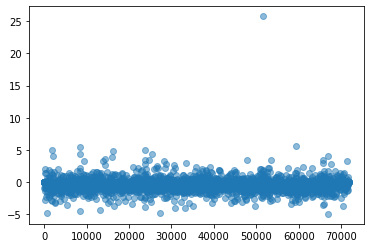

In [161]:
plt.scatter(list(range(len(profit))), profit.flatten(), alpha=0.5)

In [146]:
abs(y_pred).mean(), y_pred.mean(), y_pred.min(), y_pred.max()

(0.028728923, -0.027993169, -0.92990303, 0.056388892)

In [236]:
y_pred2 = model.predict(X[:-1-leftover-buffer])

In [238]:
abs(y_pred2).mean(), y_pred2.mean(), y_pred2.min(), y_pred2.max()

(0.09669923, -0.09057495, 0.31497744, 0.09925839)

In [234]:
y_pred2[buffer:-leftover].mean(), y_pred2[buffer:-leftover].min(), y_pred2[buffer:-leftover].max(), abs(y_pred2[buffer:-leftover]).mean()

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [235]:
y_pred2[:buffer].mean(), y_pred2[:buffer].min(), y_pred2[:buffer].max(), abs(y_pred2[:buffer]).mean()

(0.10084756, -0.08812471, 0.30822742, 0.10344847)

In [ ]:
idxs = list(range(0, batch_size, 60))
margin = y_pred[:,:1][idxs]
direction = np.sign(margin)

close1 = y_true_pred[:,:1][idxs]
close2 = y_true_pred[:,1:2][idxs]
diff = close2 - close1
spread = y_true_pred[:,2:3][idxs]

x = np.mean(100 * (margin * margin_size * (diff - (spread*direction))/close1))

In [ ]:
x

In [ ]:
margin.shape, close1.shape, close2.shape, diff.shape, spread.shape

In [ ]:
inputs_train[:1]

In [ ]:
model.predict(inputs_train[:1])

In [ ]:
import numpy as np
def normalize(data, window, step):
    frame = '_1min'
    values = [c for c in data.columns if frame in c]
    ohlc = data.iloc[step - window + 1:step + 1][values].copy()

    min_low = ohlc[values].min().min()
    for c in ohlc.columns:
        ohlc[c] -= min_low

    max_high = ohlc[values].max().max()
    for c in ohlc.columns:
        ohlc[c] /= max_high

    return ohlc.values

In [ ]:
model.predict(inputs_train[-1:])

In [ ]:
np.save('preds.json', y_preds['test'])

In [ ]:
(((y_preds['test'][:,1] + 1) / 2)).mean(), (((y_preds['test'][:,2] + 1) / 2)).mean()

In [ ]:
abs(train['close_1min'].values[:-60] - train['close_1min'].values[60:]).mean()

In [ ]:
y_preds = {'train': model.predict(inputs_train[:-buffer_train]), 'test': model.predict(inputs_test[:-buffer_test])}

In [ ]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [ ]:
time_limit = 120
def get_profit(data, y_preds, times_spread=0):
    preds = y_preds[:,0].flatten()[:-time_limit]
    direction = np.sign(preds)
    b = data.shape[0] - preds.shape[0]
    close1 = data['close_1min'].values[:-b]
    close2 = data['close_1min'].values[time_limit:-b+time_limit]
    diff = close2 - close1
    spread = data['spread'].values[:-b]
    profit = 100 * (margin_size*direction * (diff - (spread*direction))) /  close1
#     profit = [p for p, pred, s, c in zip(profit, preds, spread, close1) if abs(pred) > 100*margin_size*times_spread*s/c]
    return profit

In [ ]:
def get_profit(data, y_preds, margin_lower_limit=0):
    idx = 0
    profits = 0
    margin = 0
    account_value = [1]
    old_date = data['date'].iloc[idx]
    increase = 1
    start_profit = profits
    while idx < len(y_preds) - 2:
        pred = y_preds[idx][0]
        date = data['date'].iloc[idx]
        direction = np.sign(margin)
        close =  data.iloc[idx]['close_1min']
        spread = data.iloc[idx]['spread']
        if date != old_date:
            profits += (margin * (close - (spread*direction)))
            margin = 0
            
        if abs(pred + margin) < margin_size*account_value[-1]:
            profits += (pred * (close - (spread*direction)))
            margin += pred
            
        account_value.append(1 + (margin * (close - (spread*direction))) - profits)
        idx += 1
        
    idx = -1
    direction = np.sign(margin)
    close =  data.iloc[idx]['close_1min']
    spread = data.iloc[idx]['spread']
    profits += (margin * (close - (spread*direction)))
    margin = 0
    return profits, margin, account_value

In [ ]:
p, m, v = get_profit(df[1], y_preds['test'], 0)

In [ ]:
plt.plot(v)

In [ ]:
profits_fixed = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [ ]:
temp = {'train': train.iloc[:len(profits_fixed['train'])].copy(), 'test': test.iloc[:len(profits_fixed['test'])].copy()}
temp['train']['profit'] = profits_fixed['train']
temp['test']['profit'] = profits_fixed['test']

In [ ]:
temp['train']['profit'].hist()

In [ ]:
temp['test']['profit'].hist()

In [ ]:
temp['train']['profit'].plot()

In [ ]:
temp['test']['profit'].plot()

In [ ]:
temp['train']['profit'].cumsum().plot()

In [ ]:
temp['test']['profit'].cumsum().plot()

In [ ]:
sum(temp['train']['profit'])

In [ ]:
sum(temp['test']['profit'])

In [ ]:
(252 ** 0.5) * np.mean(temp['train']['profit']) / np.std(temp['train']['profit'])

In [ ]:
(252 ** 0.5) * np.mean(temp['test']['profit']) / np.std(temp['test']['profit'])